# Início: Preparação dos dados

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random as rd
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from scipy import stats

In [70]:
%matplotlib inline

# @grellert: removendo warnings chatos
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [71]:
df = pd.read_csv(os.path.join('..','dados', 'brutos', 'StudentPerformanceFactors.csv'))

In [72]:
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


In [73]:
df = df.dropna()
print(df)

      Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0                23          84                  Low                High   
1                19          64                  Low              Medium   
2                24          98               Medium              Medium   
3                29          89                  Low              Medium   
4                19          92               Medium              Medium   
...             ...         ...                  ...                 ...   
6602             25          69                 High              Medium   
6603             23          76                 High              Medium   
6604             20          90               Medium                 Low   
6605             10          86                 High                High   
6606             15          67               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
0                     

In [74]:
# transformando grades em passou(>=60) ou não passou, para 1 e 0
class_col = 'Passed'

df[class_col] = df['Exam_Score'].apply(lambda x: 1 if x >= 70 else 0)
df[class_col].value_counts()

df = df.drop(columns=['Exam_Score'])

In [75]:
df.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Passed
count,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000
mean,19.977109,80.020853,7.034964,75.066165,1.495296,2.972719,0.247883
std,5.985460,11.550723,1.468033,14.400389,1.233984,1.028926,0.431818
min,1.000000,60.000000,4.000000,50.000000,0.000000,0.000000,0.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,0.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,0.000000
75%,24.000000,90.000000,8.000000,88.000000,2.000000,4.000000,0.000000
max,44.000000,100.000000,10.000000,100.000000,8.000000,6.000000,1.000000


In [81]:
TH_CATEGORICO = 4
categoricos = [] 
string = []
quantitativos = []
nao_numericos = []

for col in df:
    unicos = df[col].unique()
    ## dividindo colunas entre valores categoricos e quantitativos:
    if unicos.shape[0] < TH_CATEGORICO:
        categoricos.append(col)
    else: 
        quantitativos.append(col)
print(f'colunas categoricas: {categoricos}, quantitativas: {quantitativos}')

colunas categoricas: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Passed'], quantitativas: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


# Fase I - Estatística

## Gerador de Dados Faltantes - MAR, MNAR e MCAR

In [82]:
df_quant = df[quantitativos].copy()
# df_quant = df_quant.drop(['AGE_PERCENTIL'], axis=1)
corr_arr = []

i_max = 0
i_max1 = 0
i_max2 = 0
i_min = 0
i_min1 = 0
i_min2 = 0
max_value = 0
min_value = 0
almost_zero = 1
i_az = 0
i_az1 = 0
i_az2 = 0
max_value1 = 0
min_value1 = 0
almost_zero1 = 1

correlations = {}
for col in df_quant.columns:
    correlations[col] = df_quant[col].corr(df['Passed'])

# Identifica as colunas de maior, menor e quase zero correlação
max_col = max(correlations, key=lambda k: correlations[k])
min_col = min(correlations, key=lambda k: correlations[k])
az_col = min(correlations, key=lambda k: abs(correlations[k]))  # mais próximo de zero

max_value = correlations[max_col]
min_value = correlations[min_col]
almost_zero = correlations[az_col]

print(f'Maior correlação: {max_col}: {max_value}')
print(f'Menor correlação: {min_col}: {min_value}')
print(f'Cor. quase zero: {az_col}: {almost_zero}')


reg = LinearRegression()

for i in range(len(df_quant.columns) - 1):
    num = df_quant.iloc[i].corr(df_quant.iloc[i+1])
    if max_value1 == 0 or num > max_value1:
        max_value1 = num
        i_max1 = df_quant.columns[i]
        i_max2 = df_quant.columns[i+1]
    elif min_value1 == 0 or num < min_value1:
        min_value1 = num
        i_min1 = df_quant.columns[i]
        i_min2 = df_quant.columns[i+1]
    elif -0.05 < num < 0.05:
        almost_zero1 = num
        i_az1 = df_quant.columns[i]
        i_az2 = df_quant.columns[i+1]

print(f'{i_max1, i_max2}: {max_value1}')
print(f'{i_min1, i_min2}: {min_value1}')
print(f'{i_az1, i_az2}: {almost_zero1}')

Maior correlação: Attendance: 0.4957687095365991
Menor correlação: Sleep_Hours: -0.0015529872211901175
Cor. quase zero: Sleep_Hours: -0.0015529872211901175
('Hours_Studied', 'Attendance'): 0.9992139699877187
('Previous_Scores', 'Tutoring_Sessions'): 0.9552784498100383
(0, 0): 1


In [84]:
def _sigmoid(z):
    return 1 / (1 + np.exp(-z))

def _std(s):
    # padroniza série numérica; lida com std=0
    sd = s.std()
    v = (s - s.mean()) / (sd if (sd is not None and sd > 0) else 1.0)
    return v.fillna(0.0)

def pick_missing_indices(strategy, X, y, col, k_pct, seed=None):
    """
    Retorna índices (subset de X.index) que serão NaN em X[col].
    strategy: 'MCAR'|'MAR'|'MNAR'
    k_pct: percentual de linhas alvo (10..50)
    seed: int (ou None)
    """
    rng = np.random.default_rng(seed)
    idx = X.index
    mask_valid = X[col].notna()
    idx_valid = idx[mask_valid]
    n_valid = mask_valid.sum()
    k = min(int(len(idx) * k_pct / 100), n_valid)

    if k == 0:
        return np.array([], dtype=idx.dtype)

    if strategy == "MCAR":
        return rng.choice(idx_valid, size=k, replace=False)

    # --- utilitários locais ---
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def _std(s):
        sd = s.std()
        v = (s - s.mean()) / (sd if (sd is not None and sd > 0) else 1.0)
        return v.fillna(0.0)

    if strategy == "MAR":
        predictors = [c for c in ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
                      if c in X.columns and c != col]
        z = np.zeros(n_valid, dtype=float)
        if predictors:
            # pega 1-2 simples
            for p in predictors[:2]:
                z += _std(X.loc[idx_valid, p]).to_numpy()
        if y is not None:
            z += 0.8 * _std(y.loc[idx_valid].astype(float)).to_numpy()
        p = _sigmoid(z)

    elif strategy == "MNAR":
        s = _std(X.loc[idx_valid, col].astype(float))
        p = _sigmoid(1.2 * s.to_numpy())

    else:
        raise ValueError("strategy deve ser 'MCAR', 'MAR' ou 'MNAR'.")

    # amostra só entre válidos, ponderado
    w = p + 1e-12
    w = w / w.sum()
    return rng.choice(idx_valid, size=k, replace=False, p=w)


In [111]:
# k: % de linhas a mascarar; X: só quantitativas; y: série binária (0/1); col: coluna alvo; method: 'mean'|'median'|'knn_5'|'mice'|'missforest'|'empty'
def imputation_test(k, X, y, col, method, missing_mech='MAR', seed=None):
    rng = np.random.default_rng(seed)   # controla reprodutibilidade
    X_nan = X.copy(deep=True)

    to_nan = pick_missing_indices(missing_mech, X_nan, y, col, k, seed=seed)
    if len(to_nan) > 0:
        X_nan.loc[to_nan, col] = np.nan

    # ===== Imputação =====
    if method == 'mean':
        Xi = X_nan.copy()
        Xi[col] = Xi[col].fillna(Xi[col].mean())

    elif method == 'median':
        Xi = X_nan.copy()
        Xi[col] = Xi[col].fillna(Xi[col].median())

    elif method.startswith("knn_"):
        n = int(method.split("_")[1])
        imputer = KNNImputer(n_neighbors=n)
        Xi = pd.DataFrame(imputer.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)

    elif method == "mice":
        imp = IterativeImputer(
            random_state=seed,
            max_iter=10,
            sample_posterior=True
        )
        Xi = pd.DataFrame(imp.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)

    elif method == "missforest":
        imp = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=100, random_state=seed),
            max_iter=10,
            random_state=seed,
            sample_posterior=False
        )
        Xi = pd.DataFrame(imp.fit_transform(X_nan), columns=X_nan.columns, index=X_nan.index)
        
    elif method == 'empty':
        Xi = X_nan.copy()

    else:
        print("method not available or invalid")
        return None

    return Xi, y


def compare(one_col_orig: pd.Series, one_col_imputed: pd.Series, y: pd.Series):
    # garantir alinhamento e tipo do desfecho
    one_col_imputed = one_col_imputed.astype(float)
    one_col_orig = one_col_orig.loc[one_col_imputed.index].astype(float)
    y = y.loc[one_col_imputed.index].astype(float)

    d_mean = one_col_imputed.mean()   - one_col_orig.mean()
    d_std = one_col_imputed.std()    - one_col_orig.std()
    d_median = one_col_imputed.median() - one_col_orig.median()
    d_min = one_col_imputed.min()    - one_col_orig.min()
    d_max = one_col_imputed.max()    - one_col_orig.max()
    corr = one_col_imputed.corr(y)

    return [d_mean, d_std, d_median, d_min, d_max, corr]


def test_column(X, y, col, method, missing_mech='MAR'):
    rows = []
    ks = (10, 20, 30, 40, 50)
    reps = 50
    seed_base = 2025  # fixa base para reprodutibilidade

    for k in ks:
        for r in range(reps):
            seed = seed_base + 1000*k + r
            out = imputation_test(k, X, y, col, method, missing_mech=missing_mech, seed=seed)
            if out is None:
                continue
            Xi, yi = out
            deltas = compare(X[col], Xi[col], yi)
            rows.append([method, k, col, missing_mech] + deltas)

    return pd.DataFrame(
        rows,
        columns=['imputation method', 'pct imputed', 'attribute', 'missing_mech',
                 'Δmean', 'Δstd', 'Δmedian', 'Δmin', 'Δmax', 'correl']
    )


def generate_results(X, y, method, missing_mech='MAR'):
    # X: apenas quantitativas; y: Série desfecho 0/1
    dfs = []
    for col in X.columns:
        print(f"Processing {col} with {method}")
        dfs.append(test_column(X, y, col, method, missing_mech=missing_mech))
    return pd.concat(dfs, ignore_index=True)


def generate_vis(df_vis, coluna, value):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,25))
    
    sns.boxplot(ax=axes[0], x = 'pct imputed', y = 'Δmean', hue = 'imputation method', data = df_vis[df_vis['attribute'] == coluna], palette="pastel"); 
    sns.boxplot(ax=axes[1], x = 'pct imputed', y = 'Δmedian', hue = 'imputation method', data = df_vis[df_vis['attribute'] == coluna], palette="pastel"); 
    sns.boxplot(ax=axes[2], x = 'pct imputed', y = 'Δstd', hue = 'imputation method', data = df_vis[df_vis['attribute'] == coluna], palette="pastel"); 
    sns.boxplot(ax=axes[3], x = 'pct imputed', y = 'correl', hue = 'imputation method', data = df_vis[df_vis['attribute'] == coluna], palette="pastel",showfliers = False); 

    axes[0].set_title(coluna)
    axes[1].set_title(coluna)
    axes[2].set_title(coluna)
    axes[3].set_title(coluna)
    
        
    axes[0].axhline(y=0, linestyle = '--')
    axes[1].axhline(y=0, linestyle = '--')
    axes[2].axhline(y=0, linestyle = '--')
    axes[3].axhline(y=value, linestyle = '--')
    # axes[3].axhline(y=1, linestyle = '--')
    # axes[3].axhline(y=-1, linestyle = '--')

## Results

### MAR

Processing Hours_Studied with mean
Processing Attendance with mean
Processing Sleep_Hours with mean
Processing Previous_Scores with mean
Processing Tutoring_Sessions with mean
Processing Physical_Activity with mean
Processing Hours_Studied with median
Processing Attendance with median
Processing Sleep_Hours with median
Processing Previous_Scores with median
Processing Tutoring_Sessions with median
Processing Physical_Activity with median
Processing Hours_Studied with knn_5
Processing Attendance with knn_5
Processing Sleep_Hours with knn_5
Processing Previous_Scores with knn_5
Processing Tutoring_Sessions with knn_5
Processing Physical_Activity with knn_5
Processing Hours_Studied with mice
Processing Attendance with mice
Processing Sleep_Hours with mice
Processing Previous_Scores with mice
Processing Tutoring_Sessions with mice
Processing Physical_Activity with mice
Processing Hours_Studied with empty
Processing Attendance with empty
Processing Sleep_Hours with empty
Processing Previous

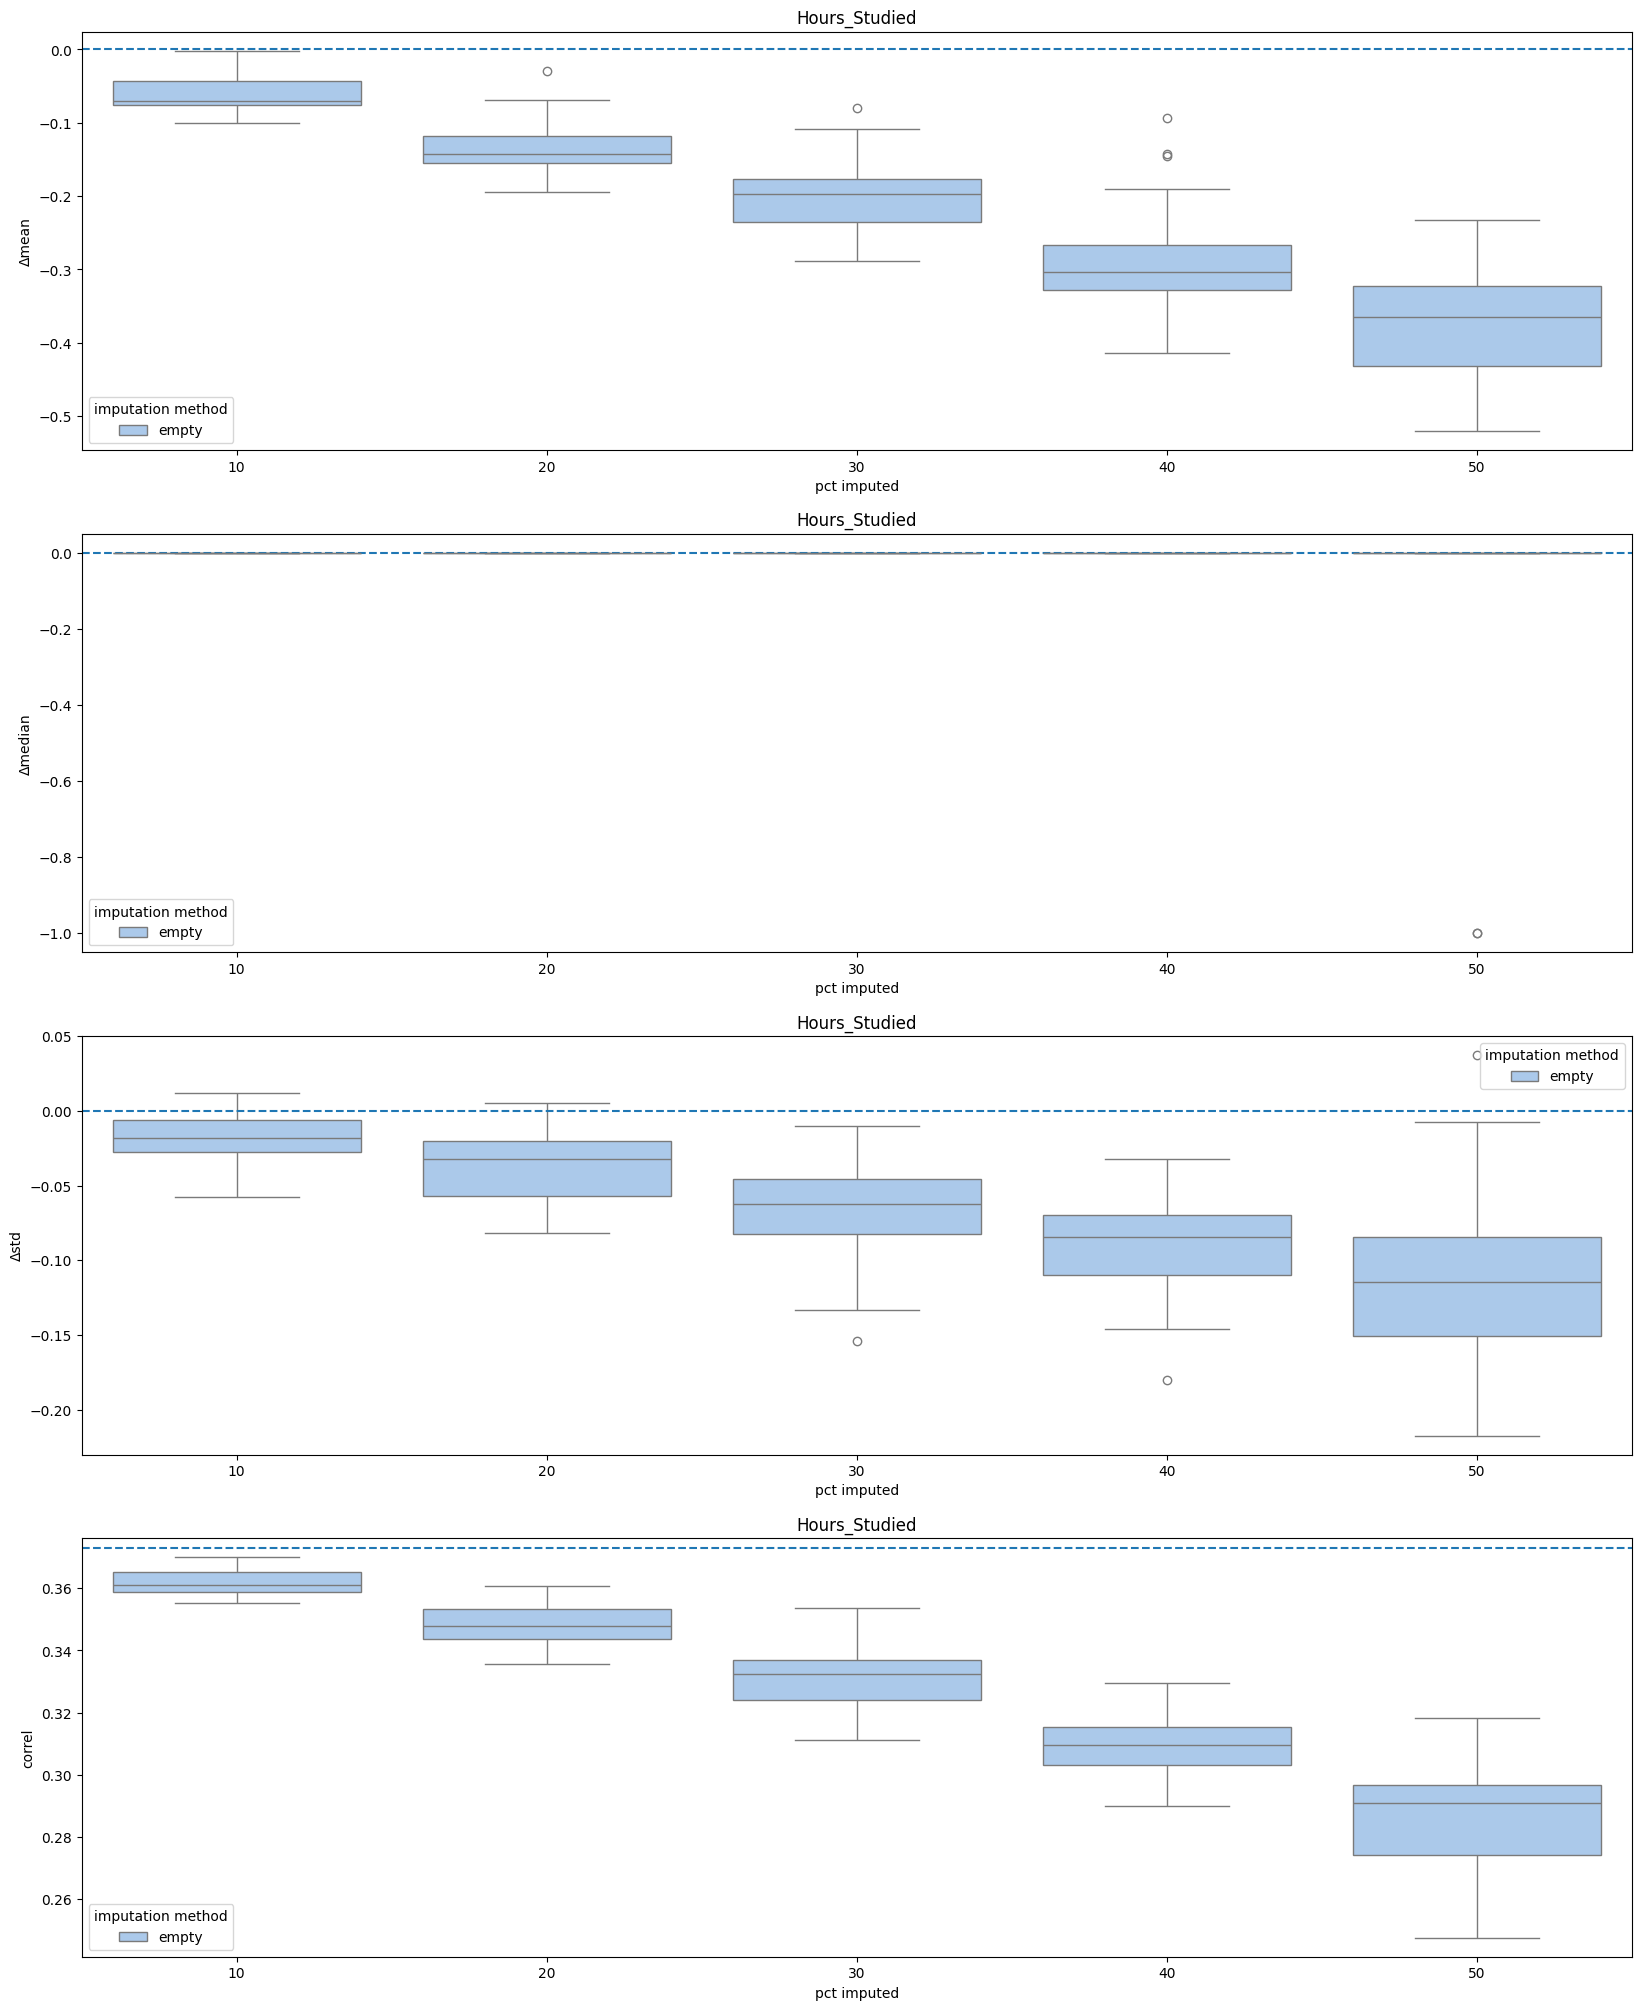

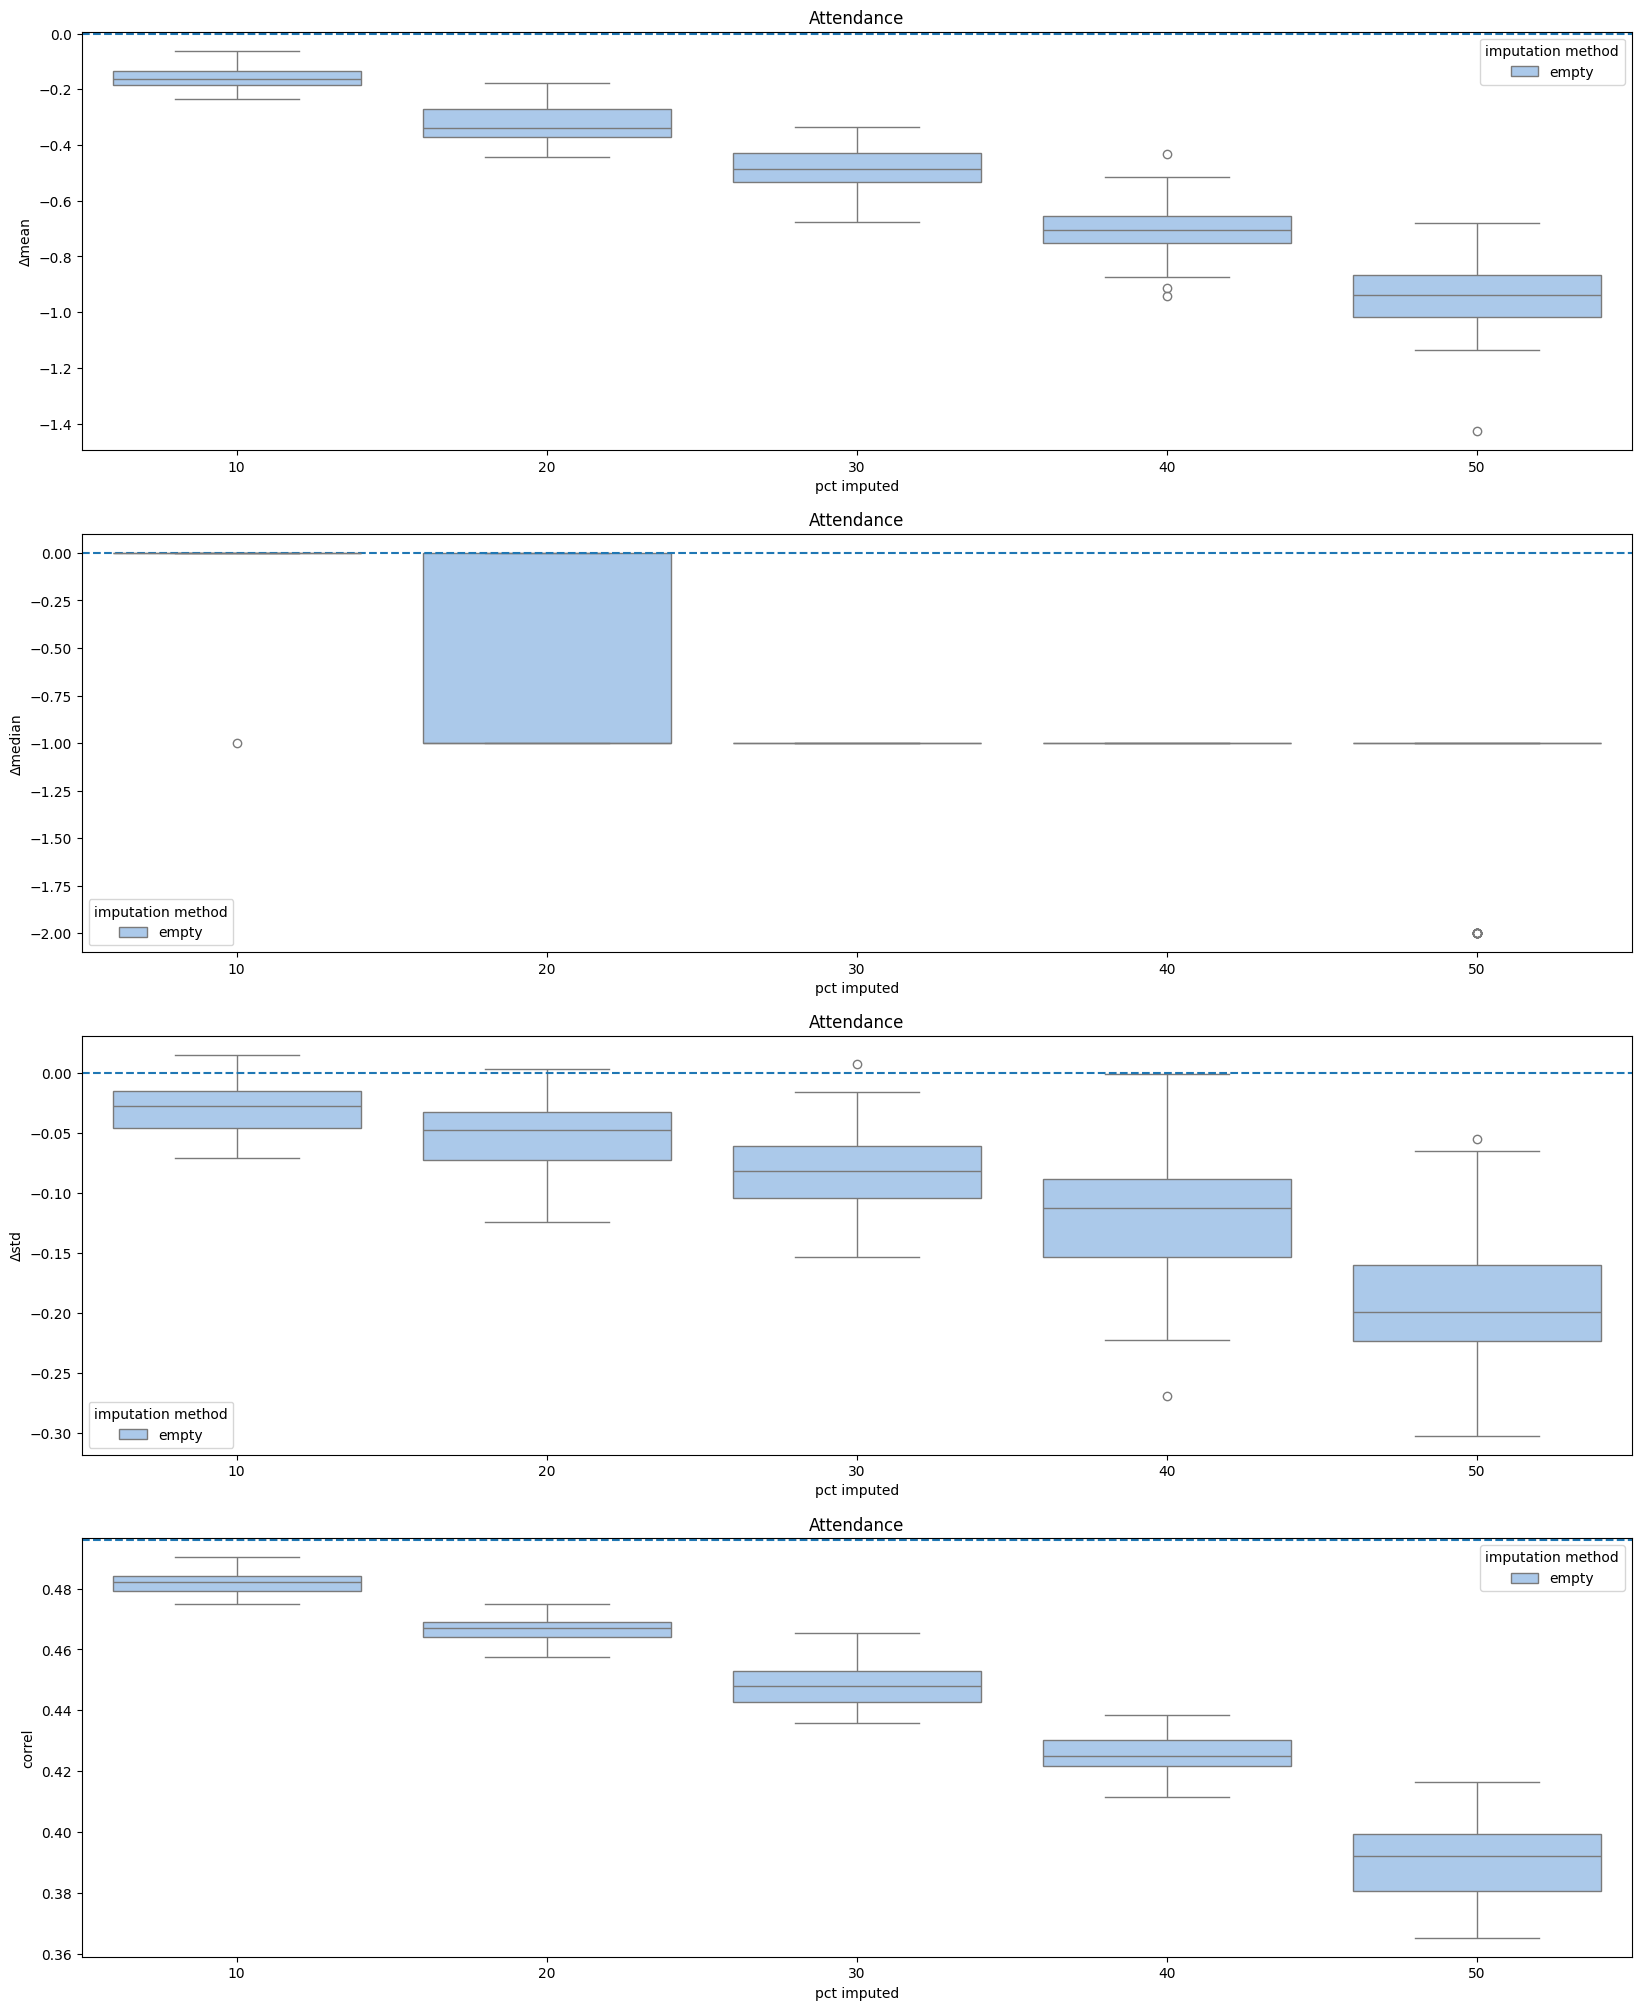

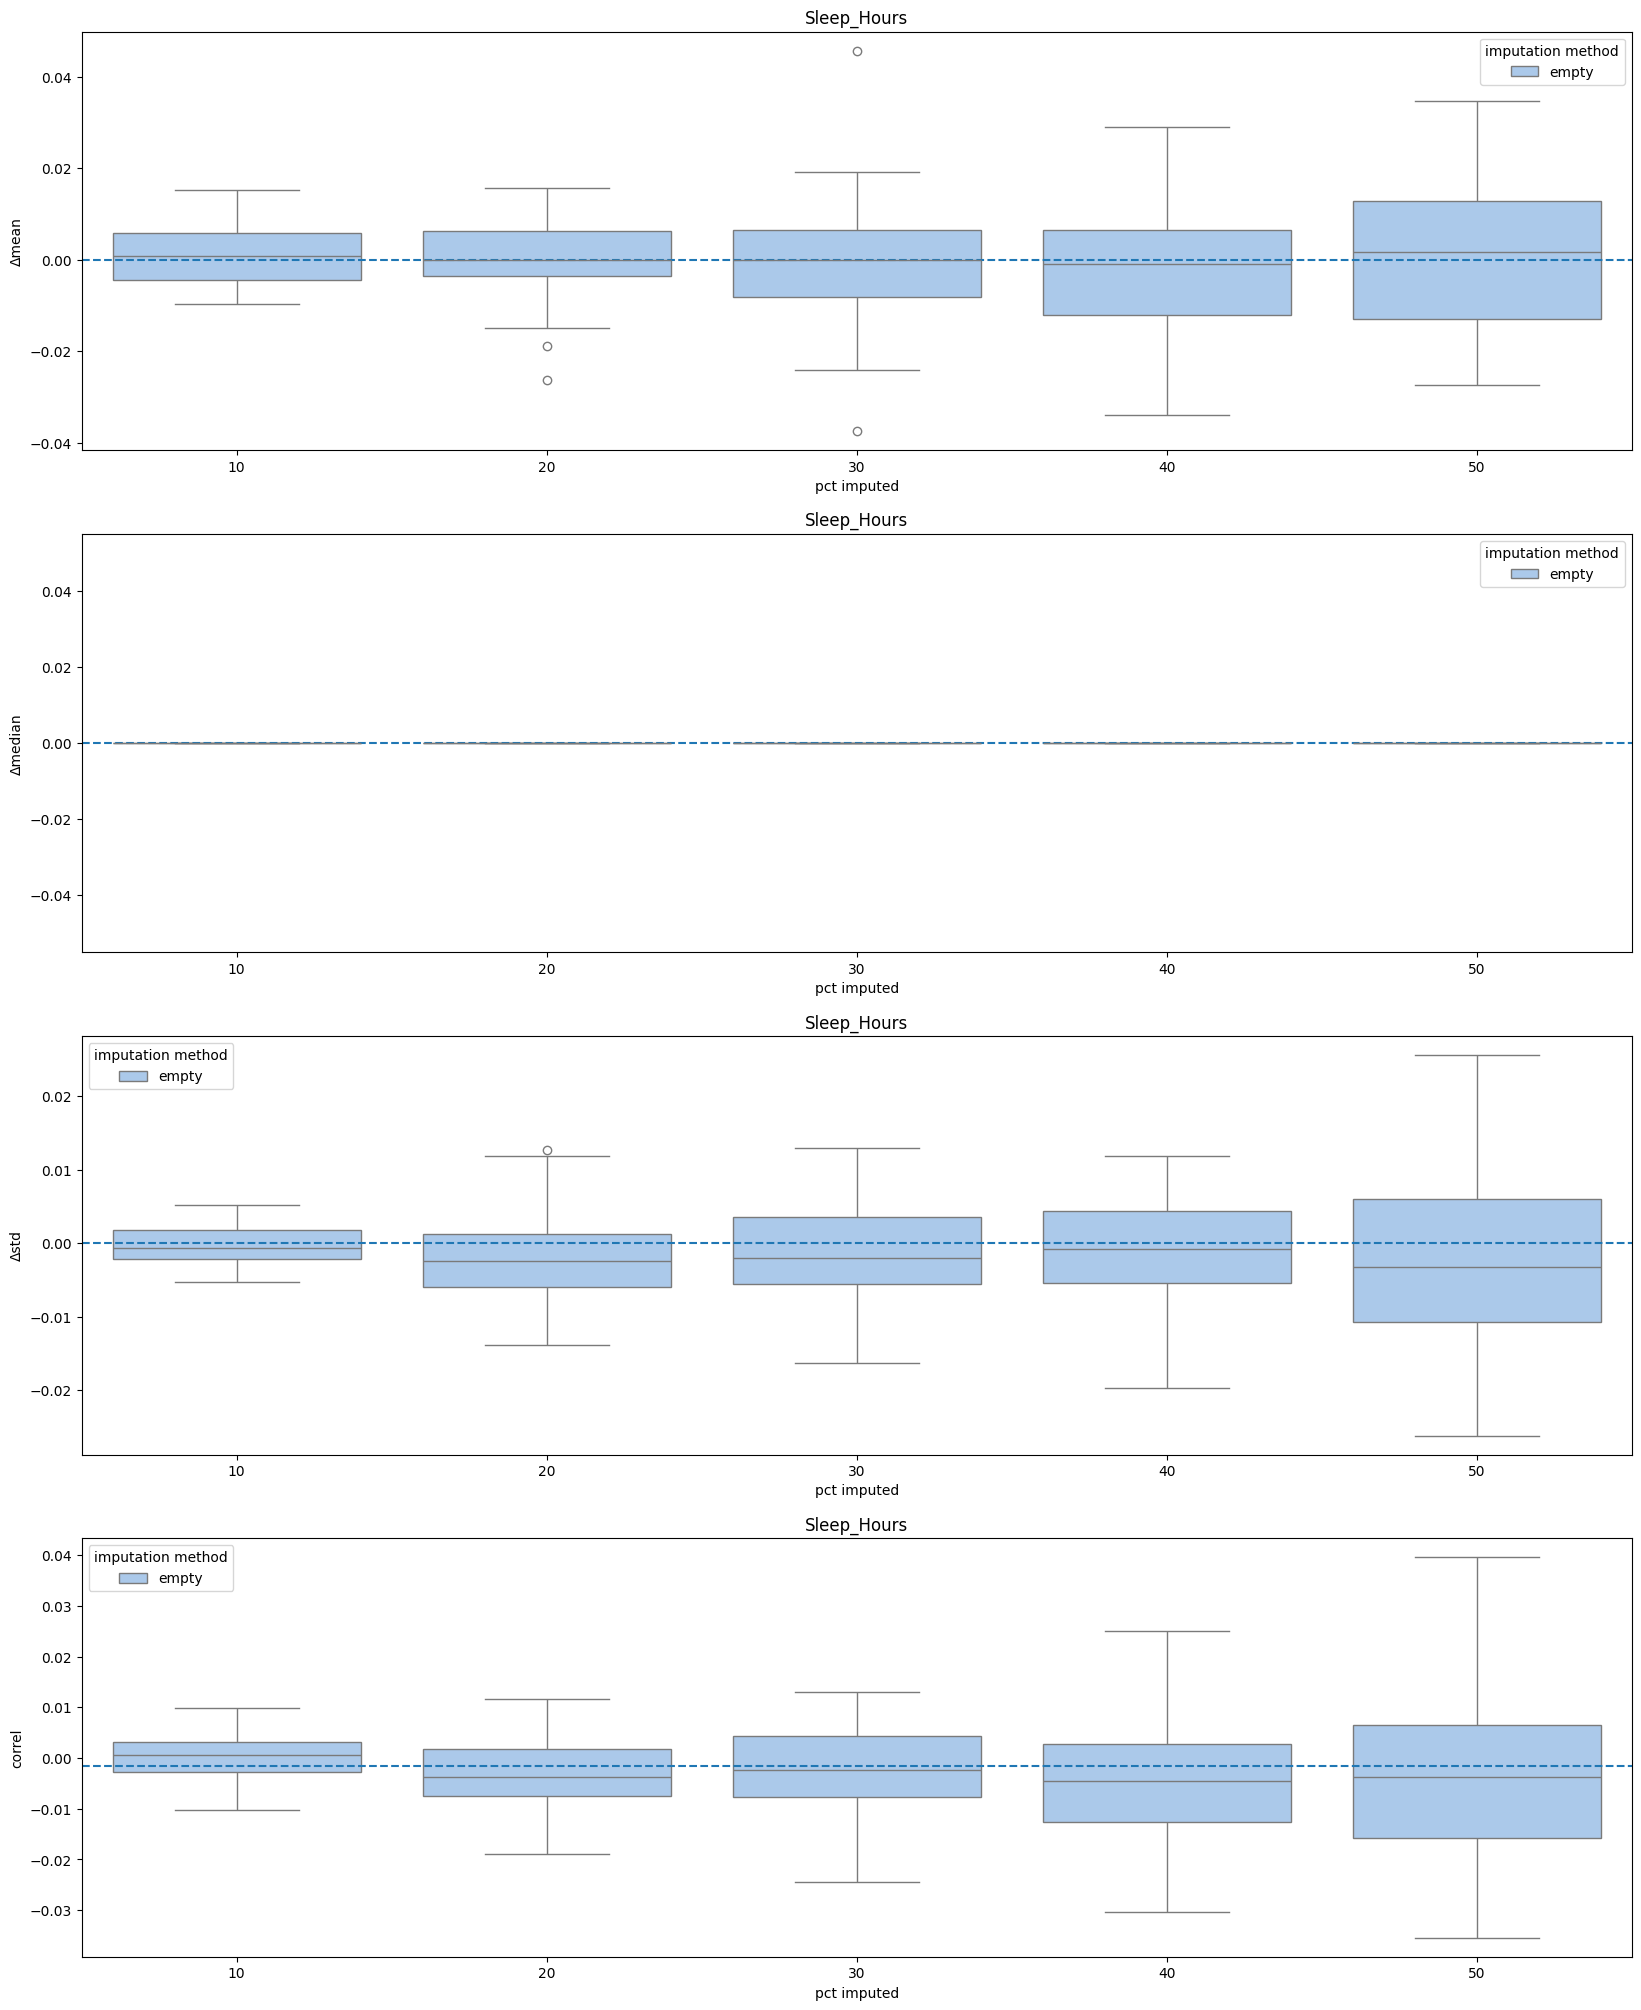

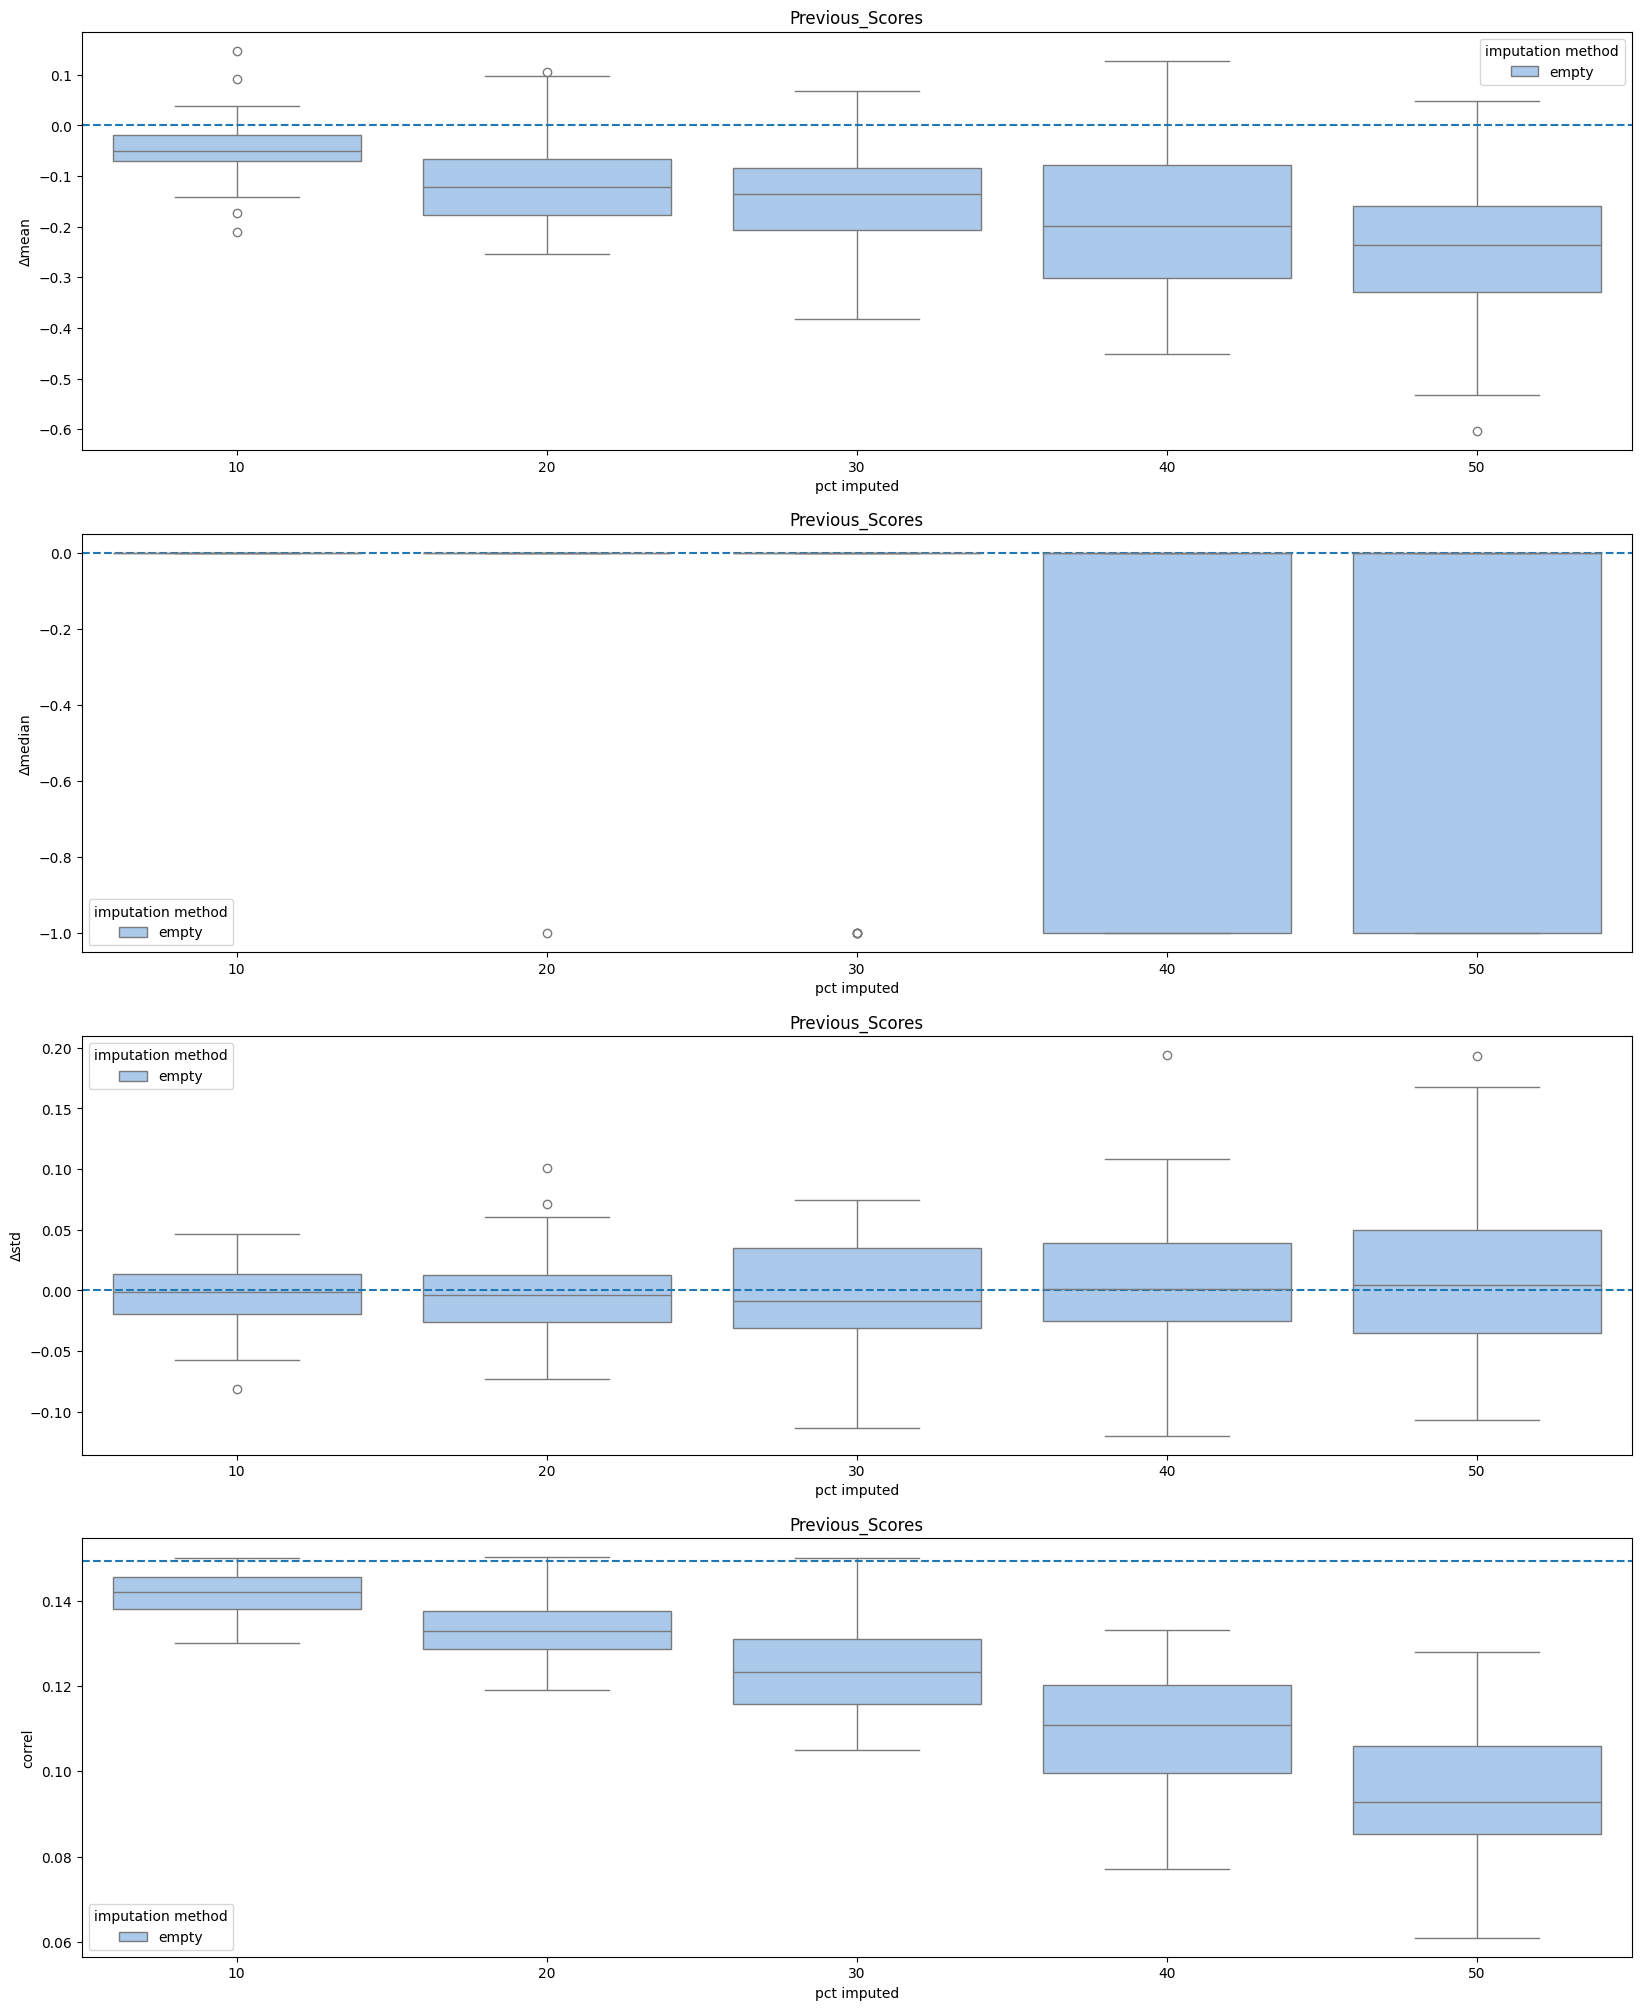

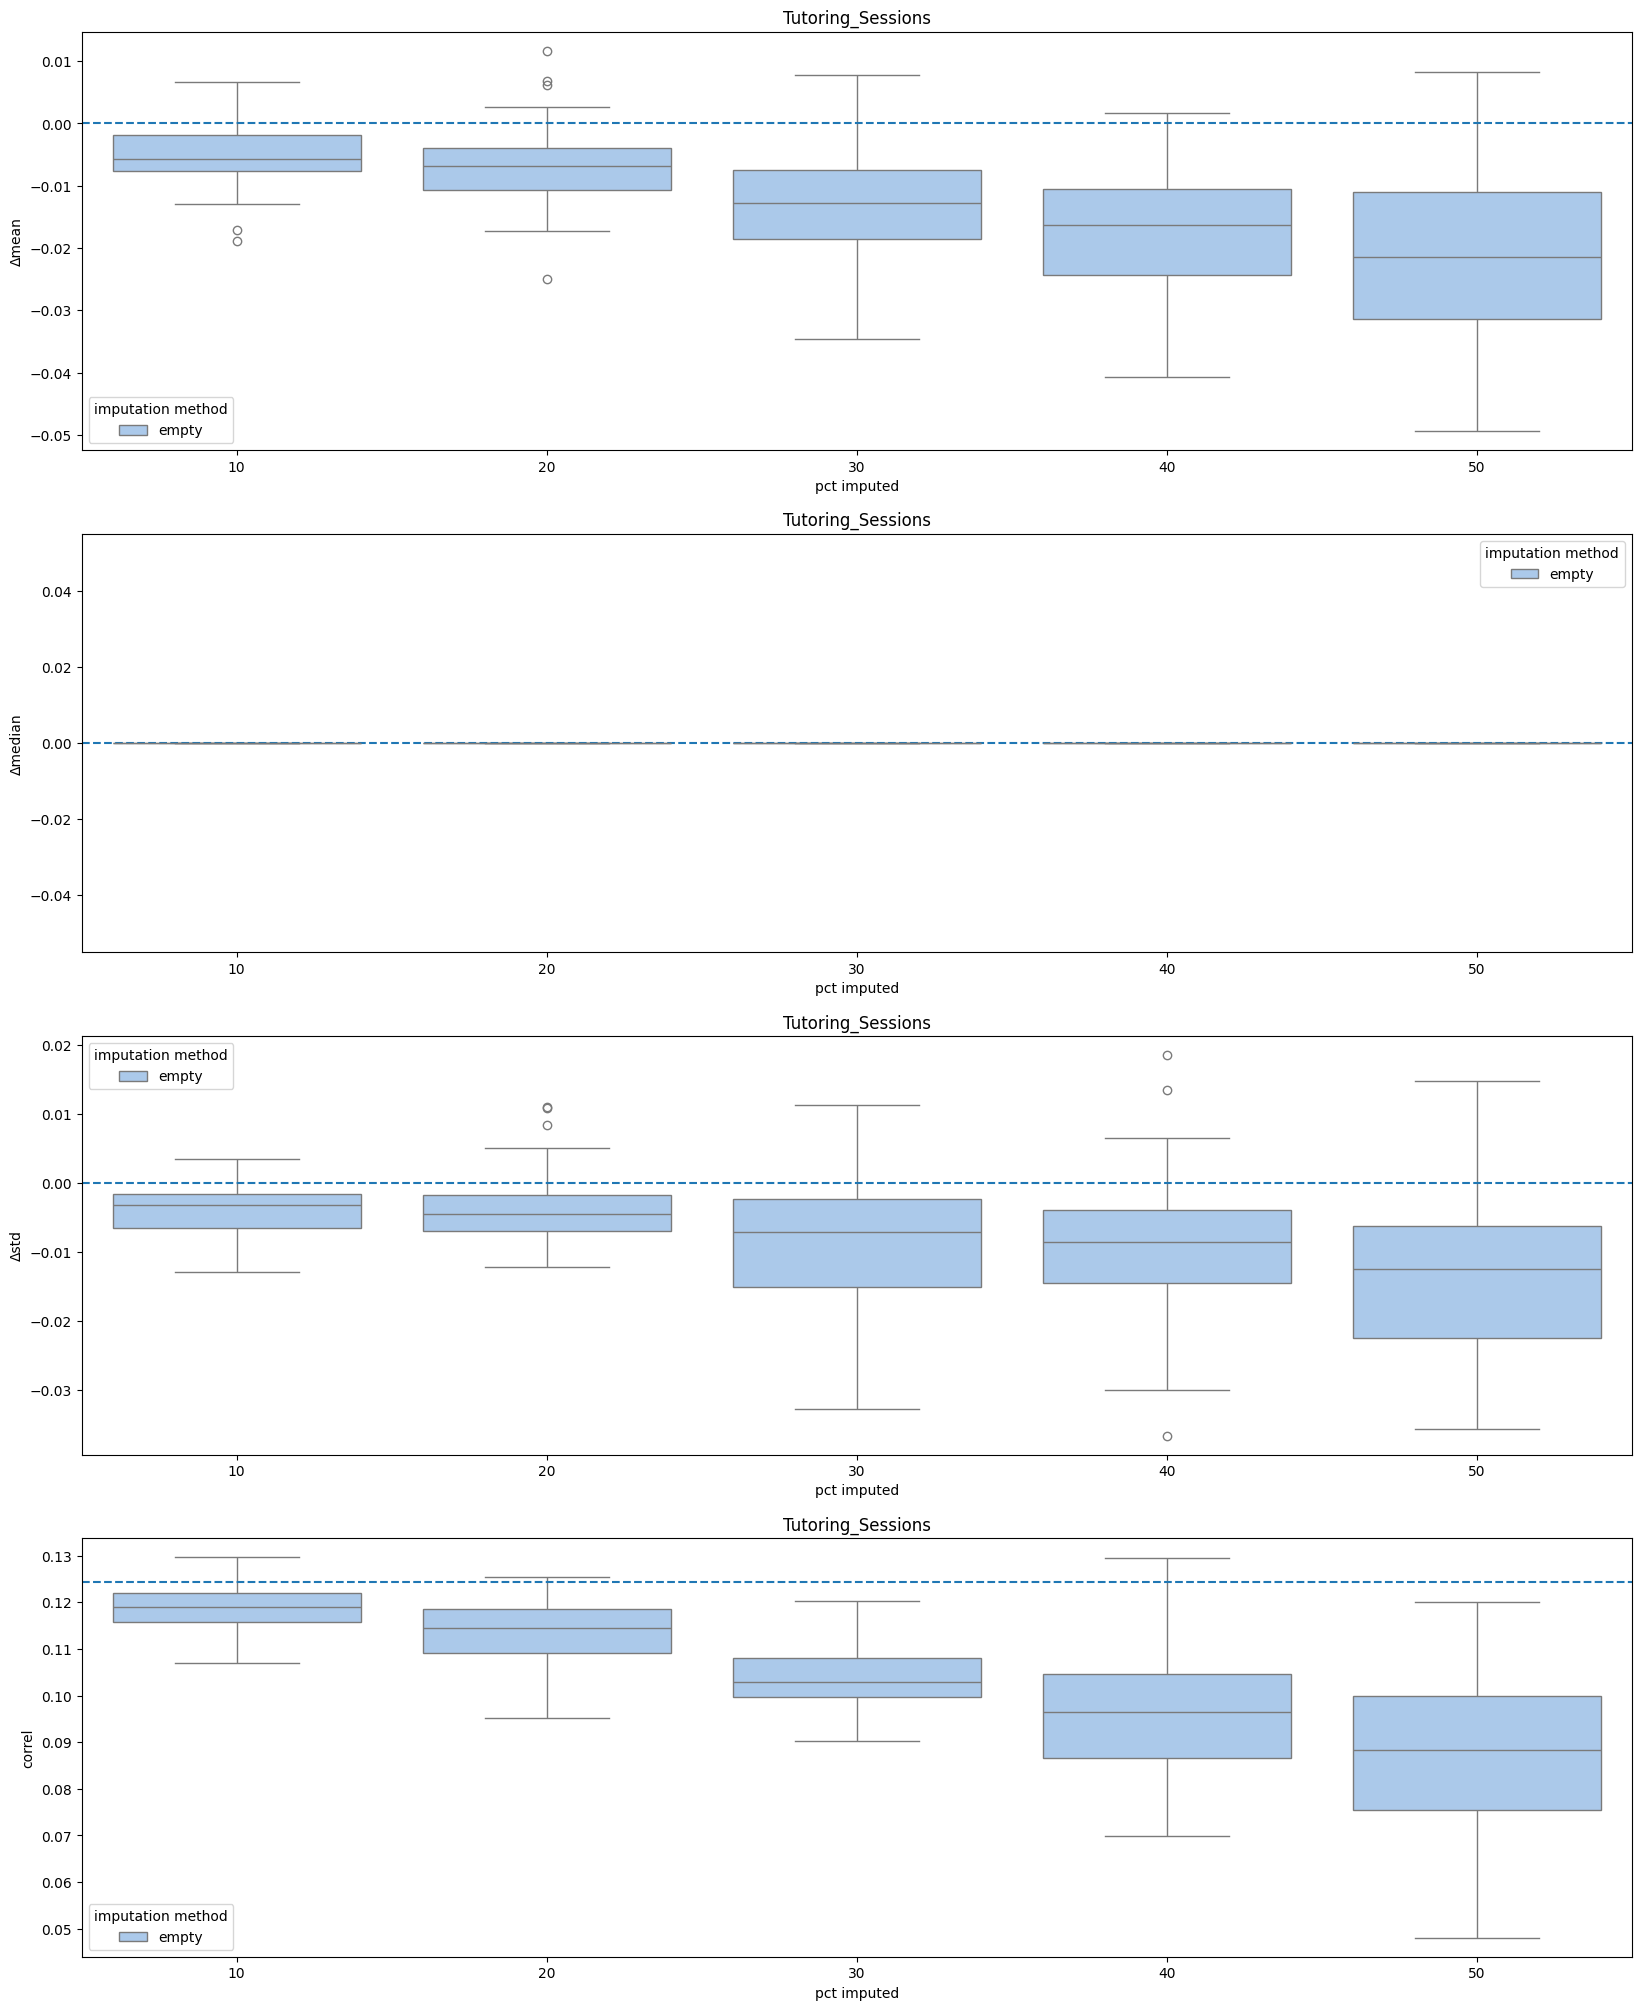

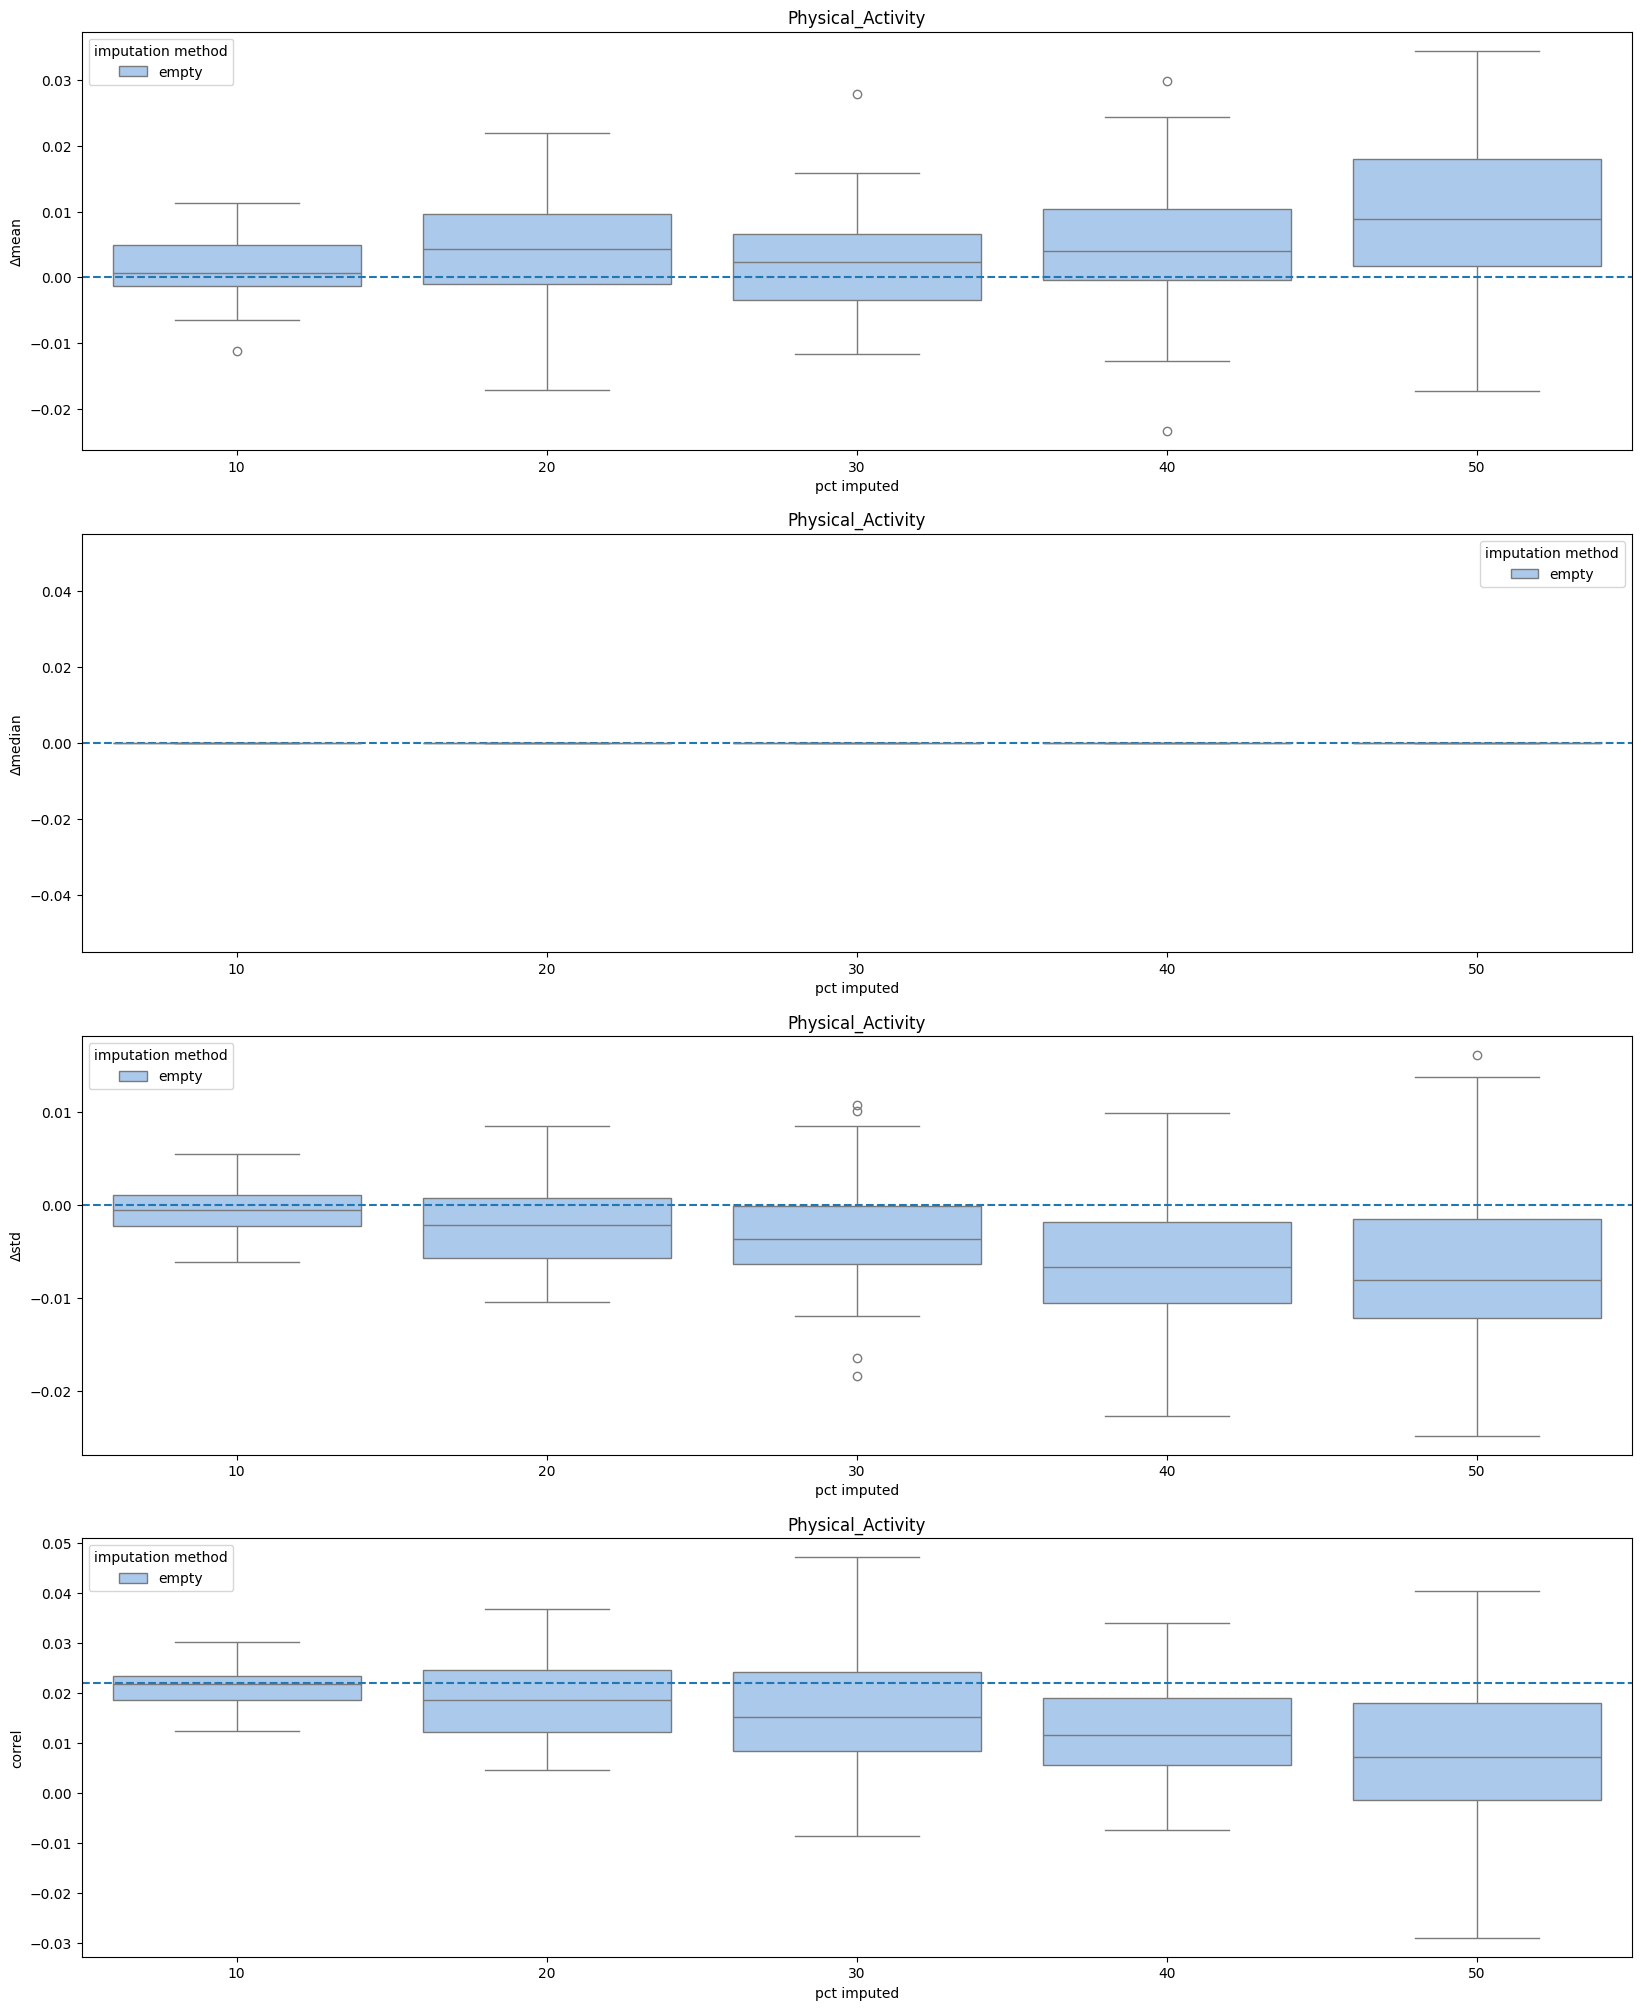

In [ ]:
class_col = 'Passed'

X = df[quantitativos].copy()
y = df[class_col].astype(int).copy()  # 0/1 

# MAR
df_vis1 = generate_results(X, y, 'mean', missing_mech='MAR')
df_vis2 = generate_results(X, y, 'median', missing_mech='MAR')
df_vis3 = generate_results(X, y, 'knn_5', missing_mech='MAR')
# df_vis4 = generate_results(X, y, 'missforest', missing_mech='MAR')
df_vis5 = generate_results(X, y, 'mice', missing_mech='MAR')
df_vis6 = generate_results(X, y, 'empty', missing_mech='MAR')

df_vis = pd.concat([df_vis1, df_vis2, df_vis3, df_vis5, df_vis6])

for col in df_quant:
    if col == max_col:
        value = max_value
    elif col == min_col:
        value = min_value
    elif col == az_col:
        value = almost_zero
    else:
        value = correlations[col]
    generate_vis(df_vis, col, value)

### MNAR

Processing Hours_Studied with mean
Processing Attendance with mean
Processing Sleep_Hours with mean
Processing Previous_Scores with mean
Processing Tutoring_Sessions with mean
Processing Physical_Activity with mean
Processing Hours_Studied with median
Processing Attendance with median
Processing Sleep_Hours with median
Processing Previous_Scores with median
Processing Tutoring_Sessions with median
Processing Physical_Activity with median
Processing Hours_Studied with knn_5
Processing Attendance with knn_5
Processing Sleep_Hours with knn_5
Processing Previous_Scores with knn_5
Processing Tutoring_Sessions with knn_5
Processing Physical_Activity with knn_5
Processing Hours_Studied with mice
Processing Attendance with mice
Processing Sleep_Hours with mice
Processing Previous_Scores with mice
Processing Tutoring_Sessions with mice
Processing Physical_Activity with mice
Processing Hours_Studied with empty
Processing Attendance with empty
Processing Sleep_Hours with empty
Processing Previous

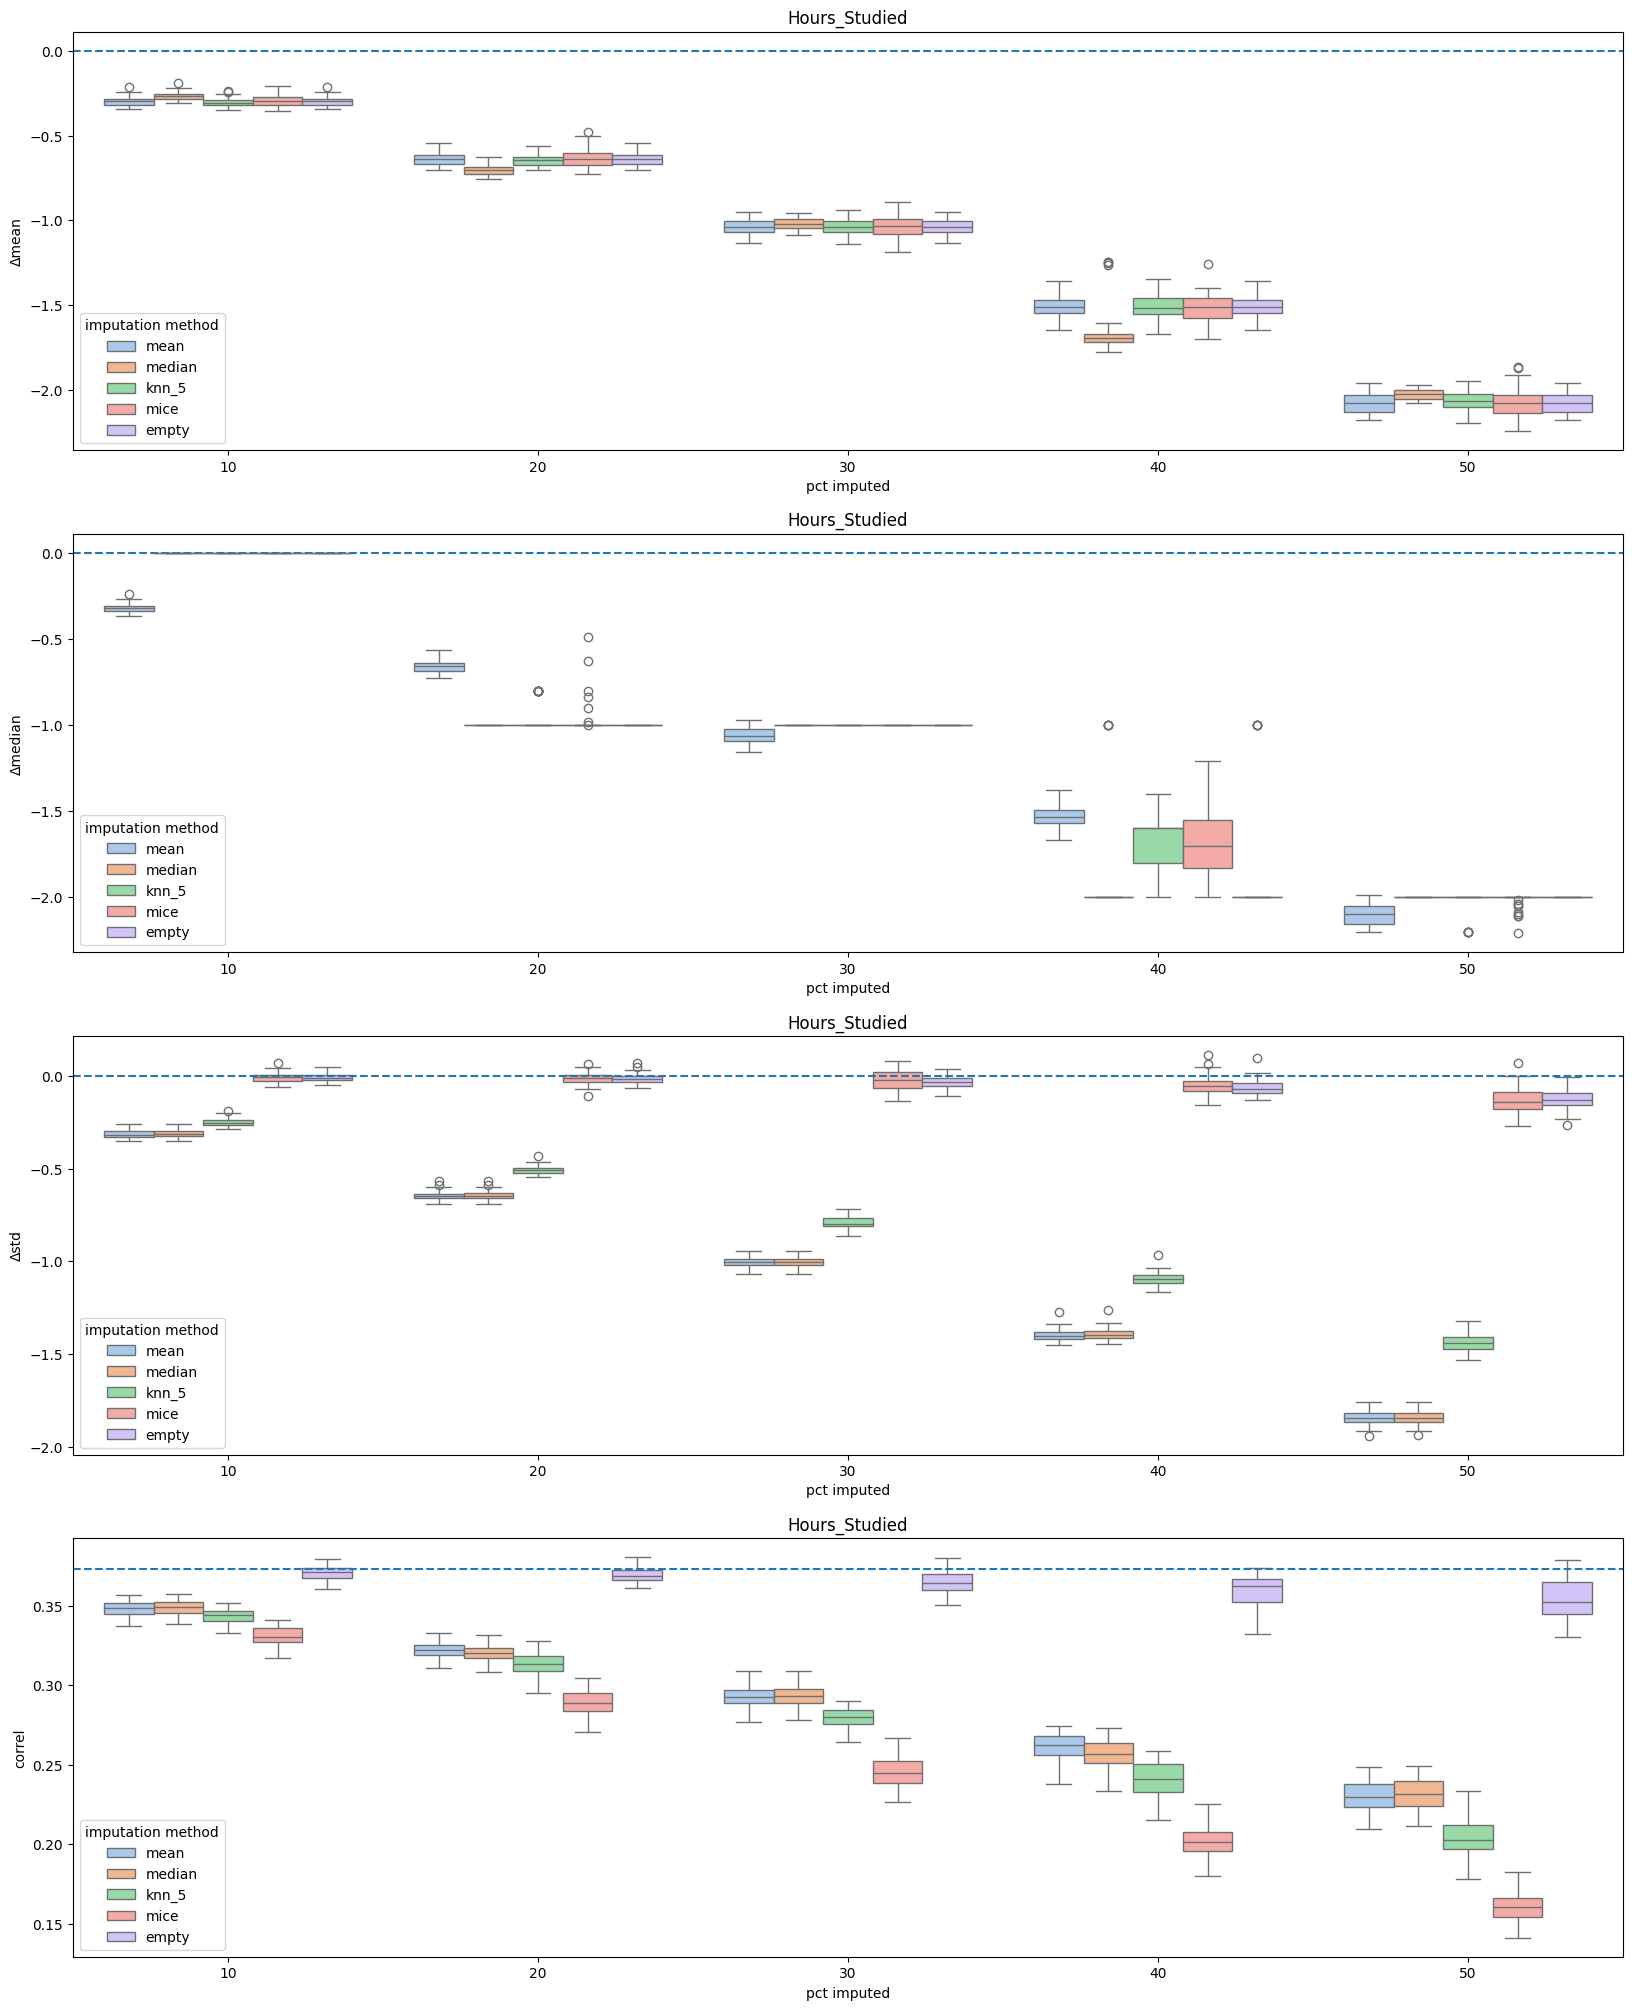

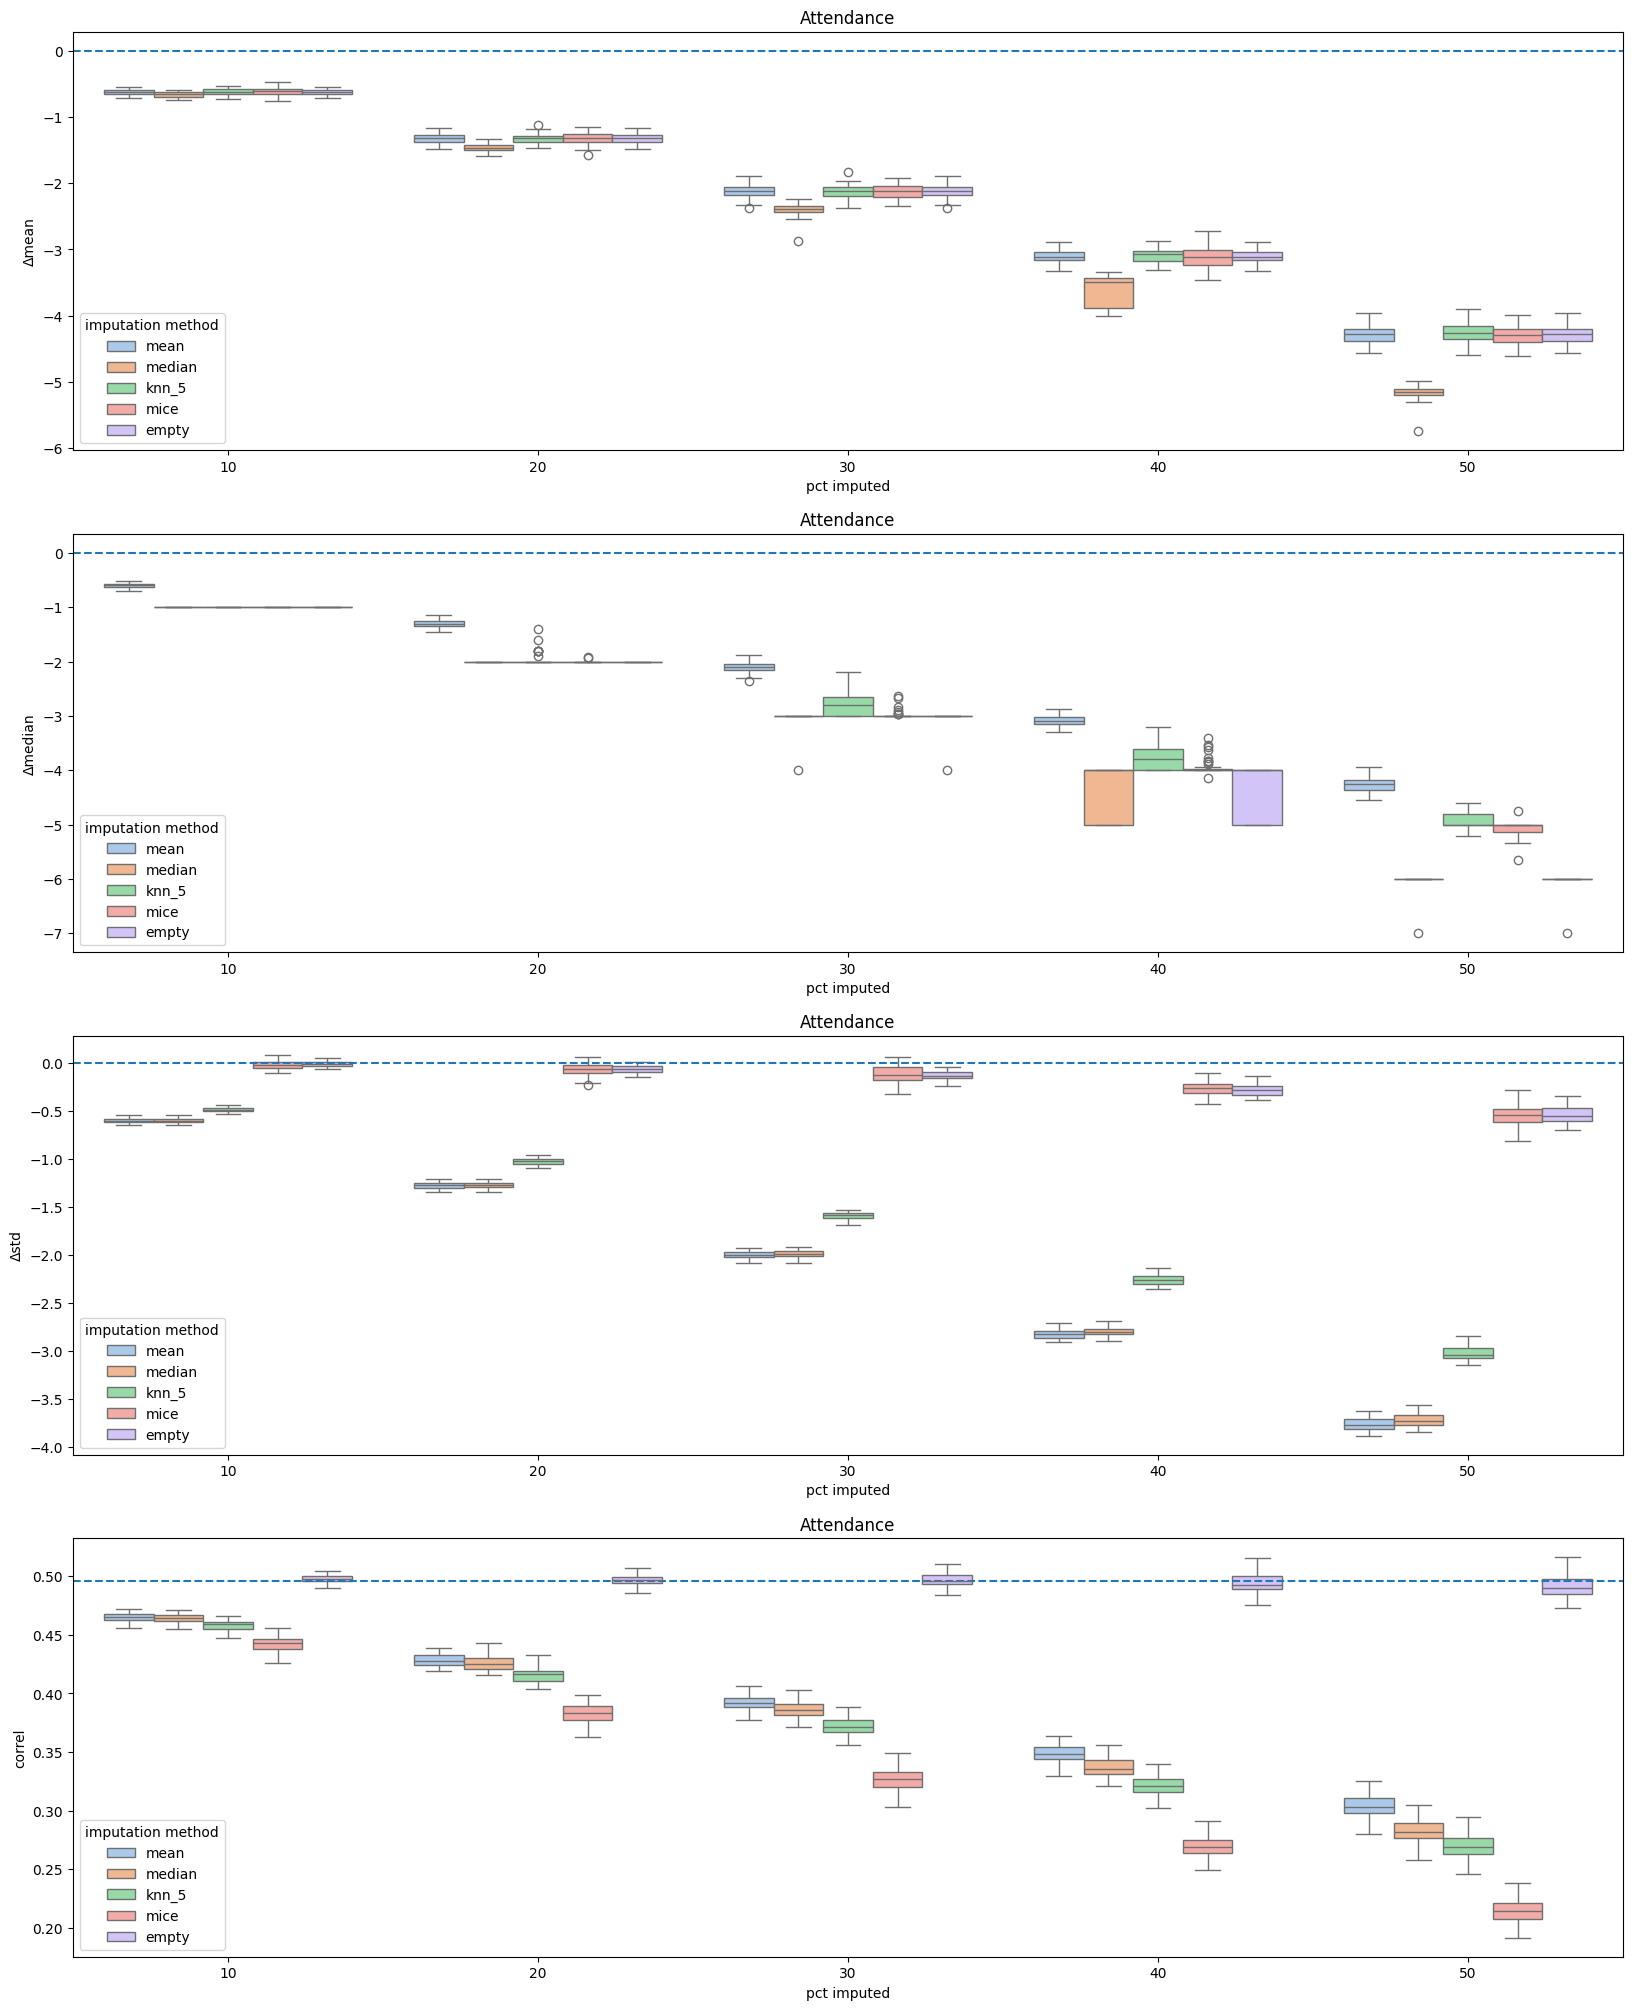

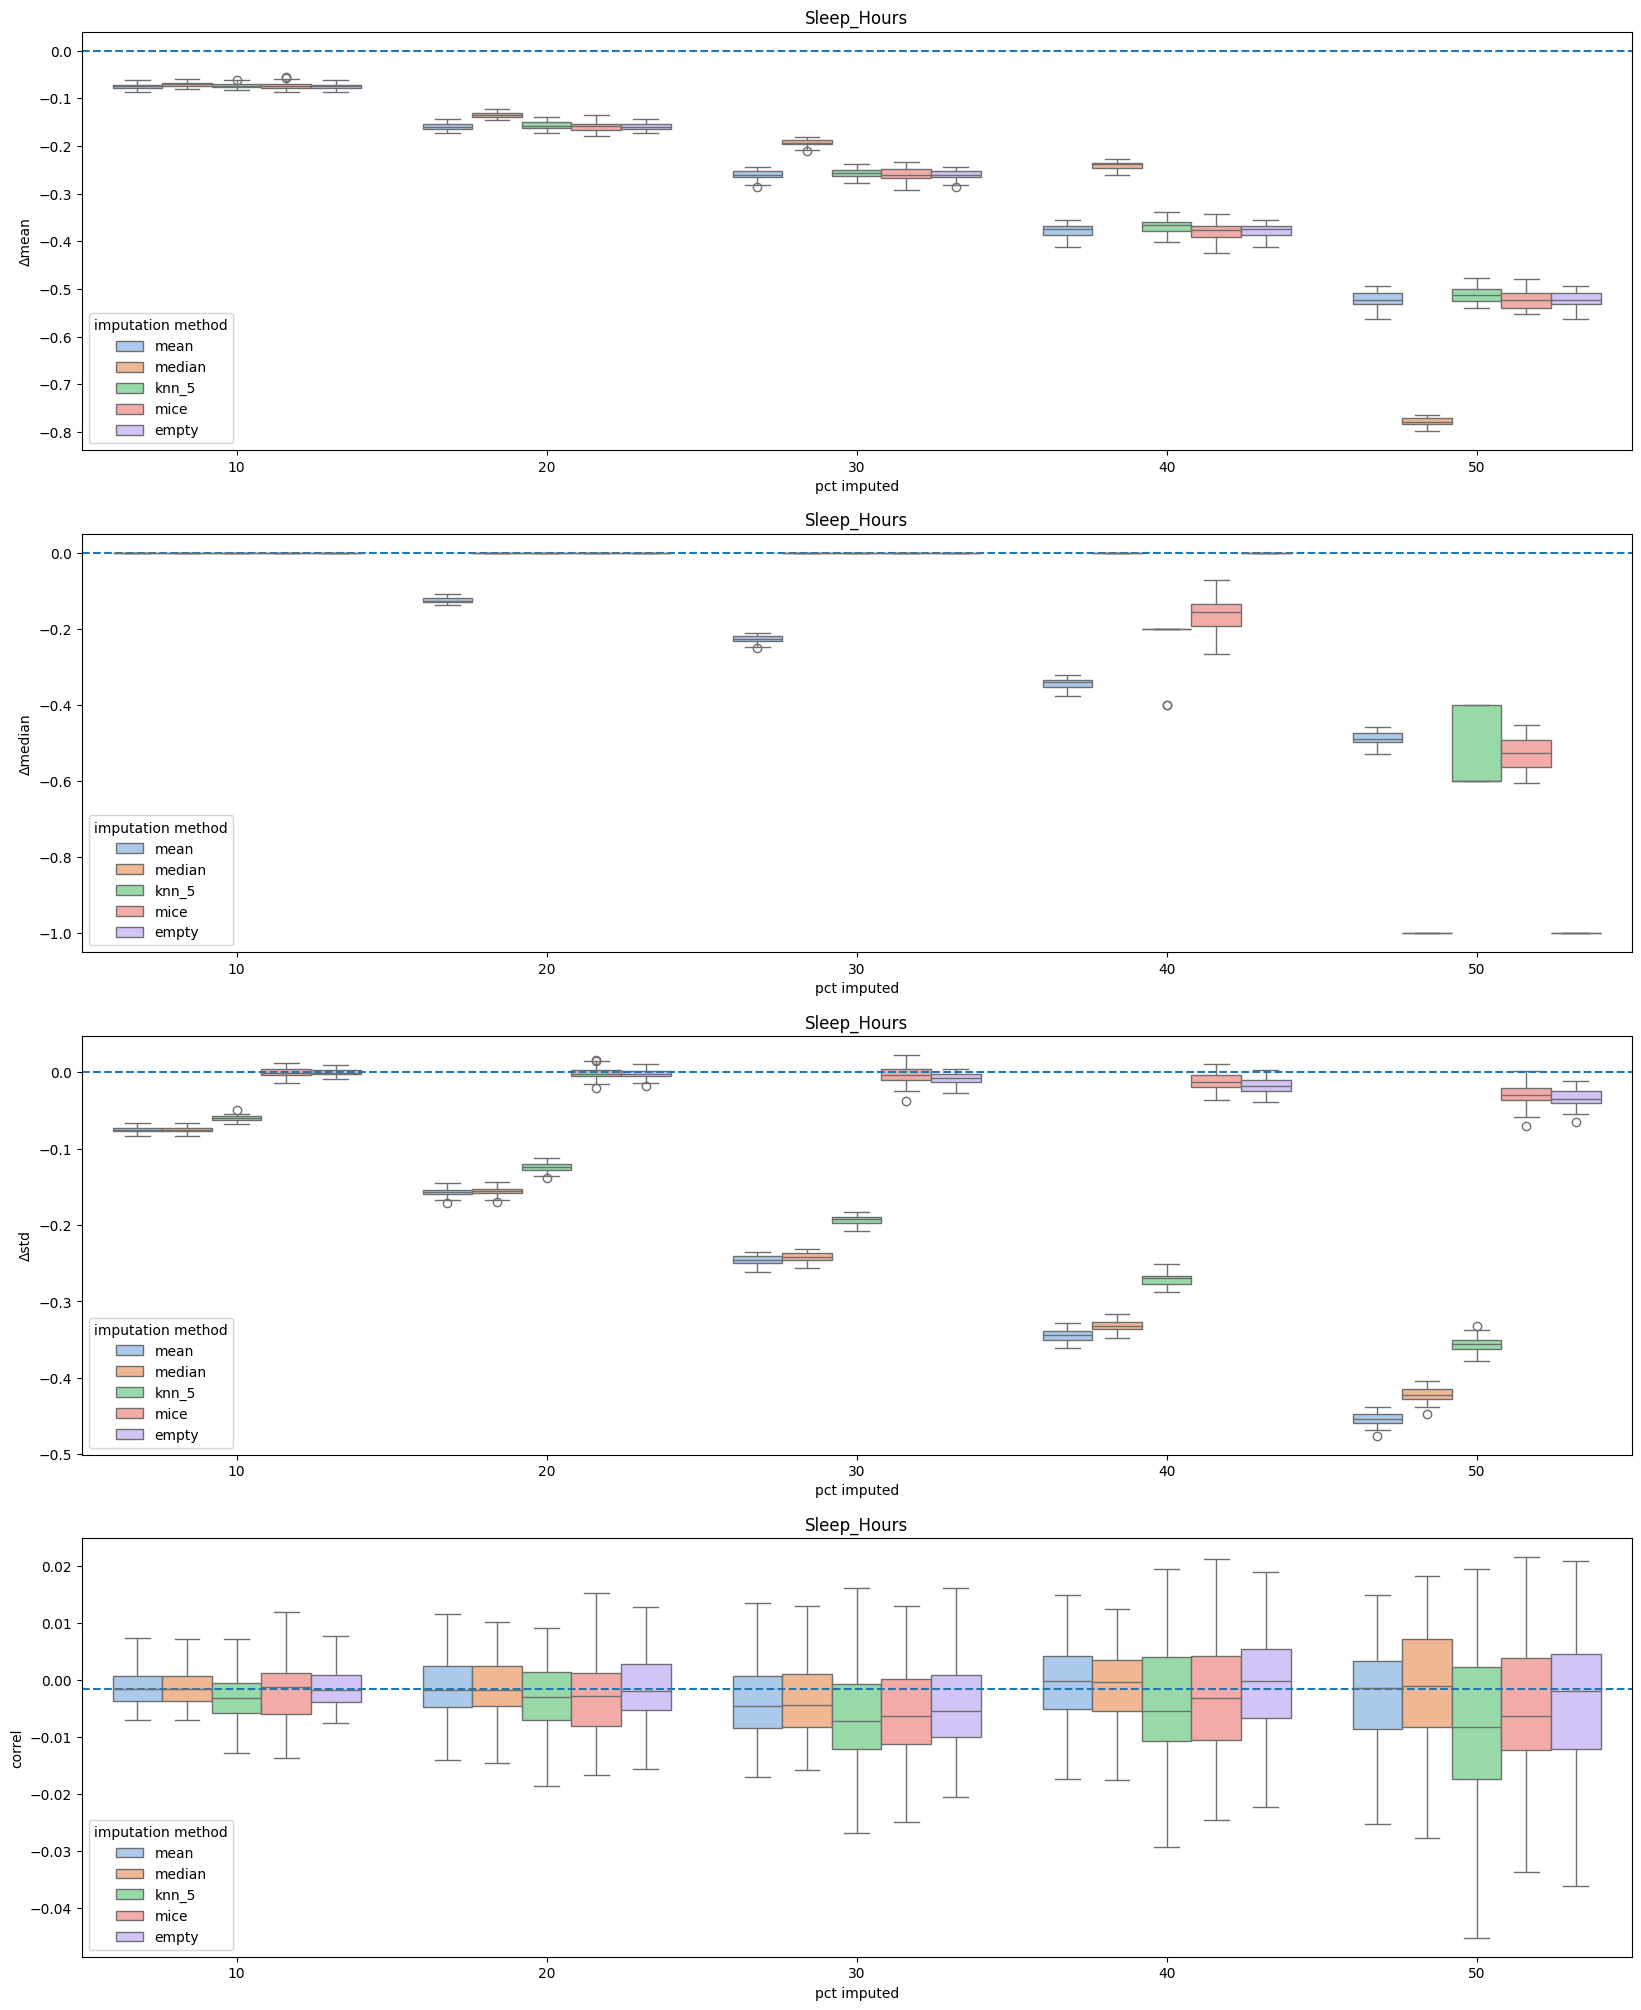

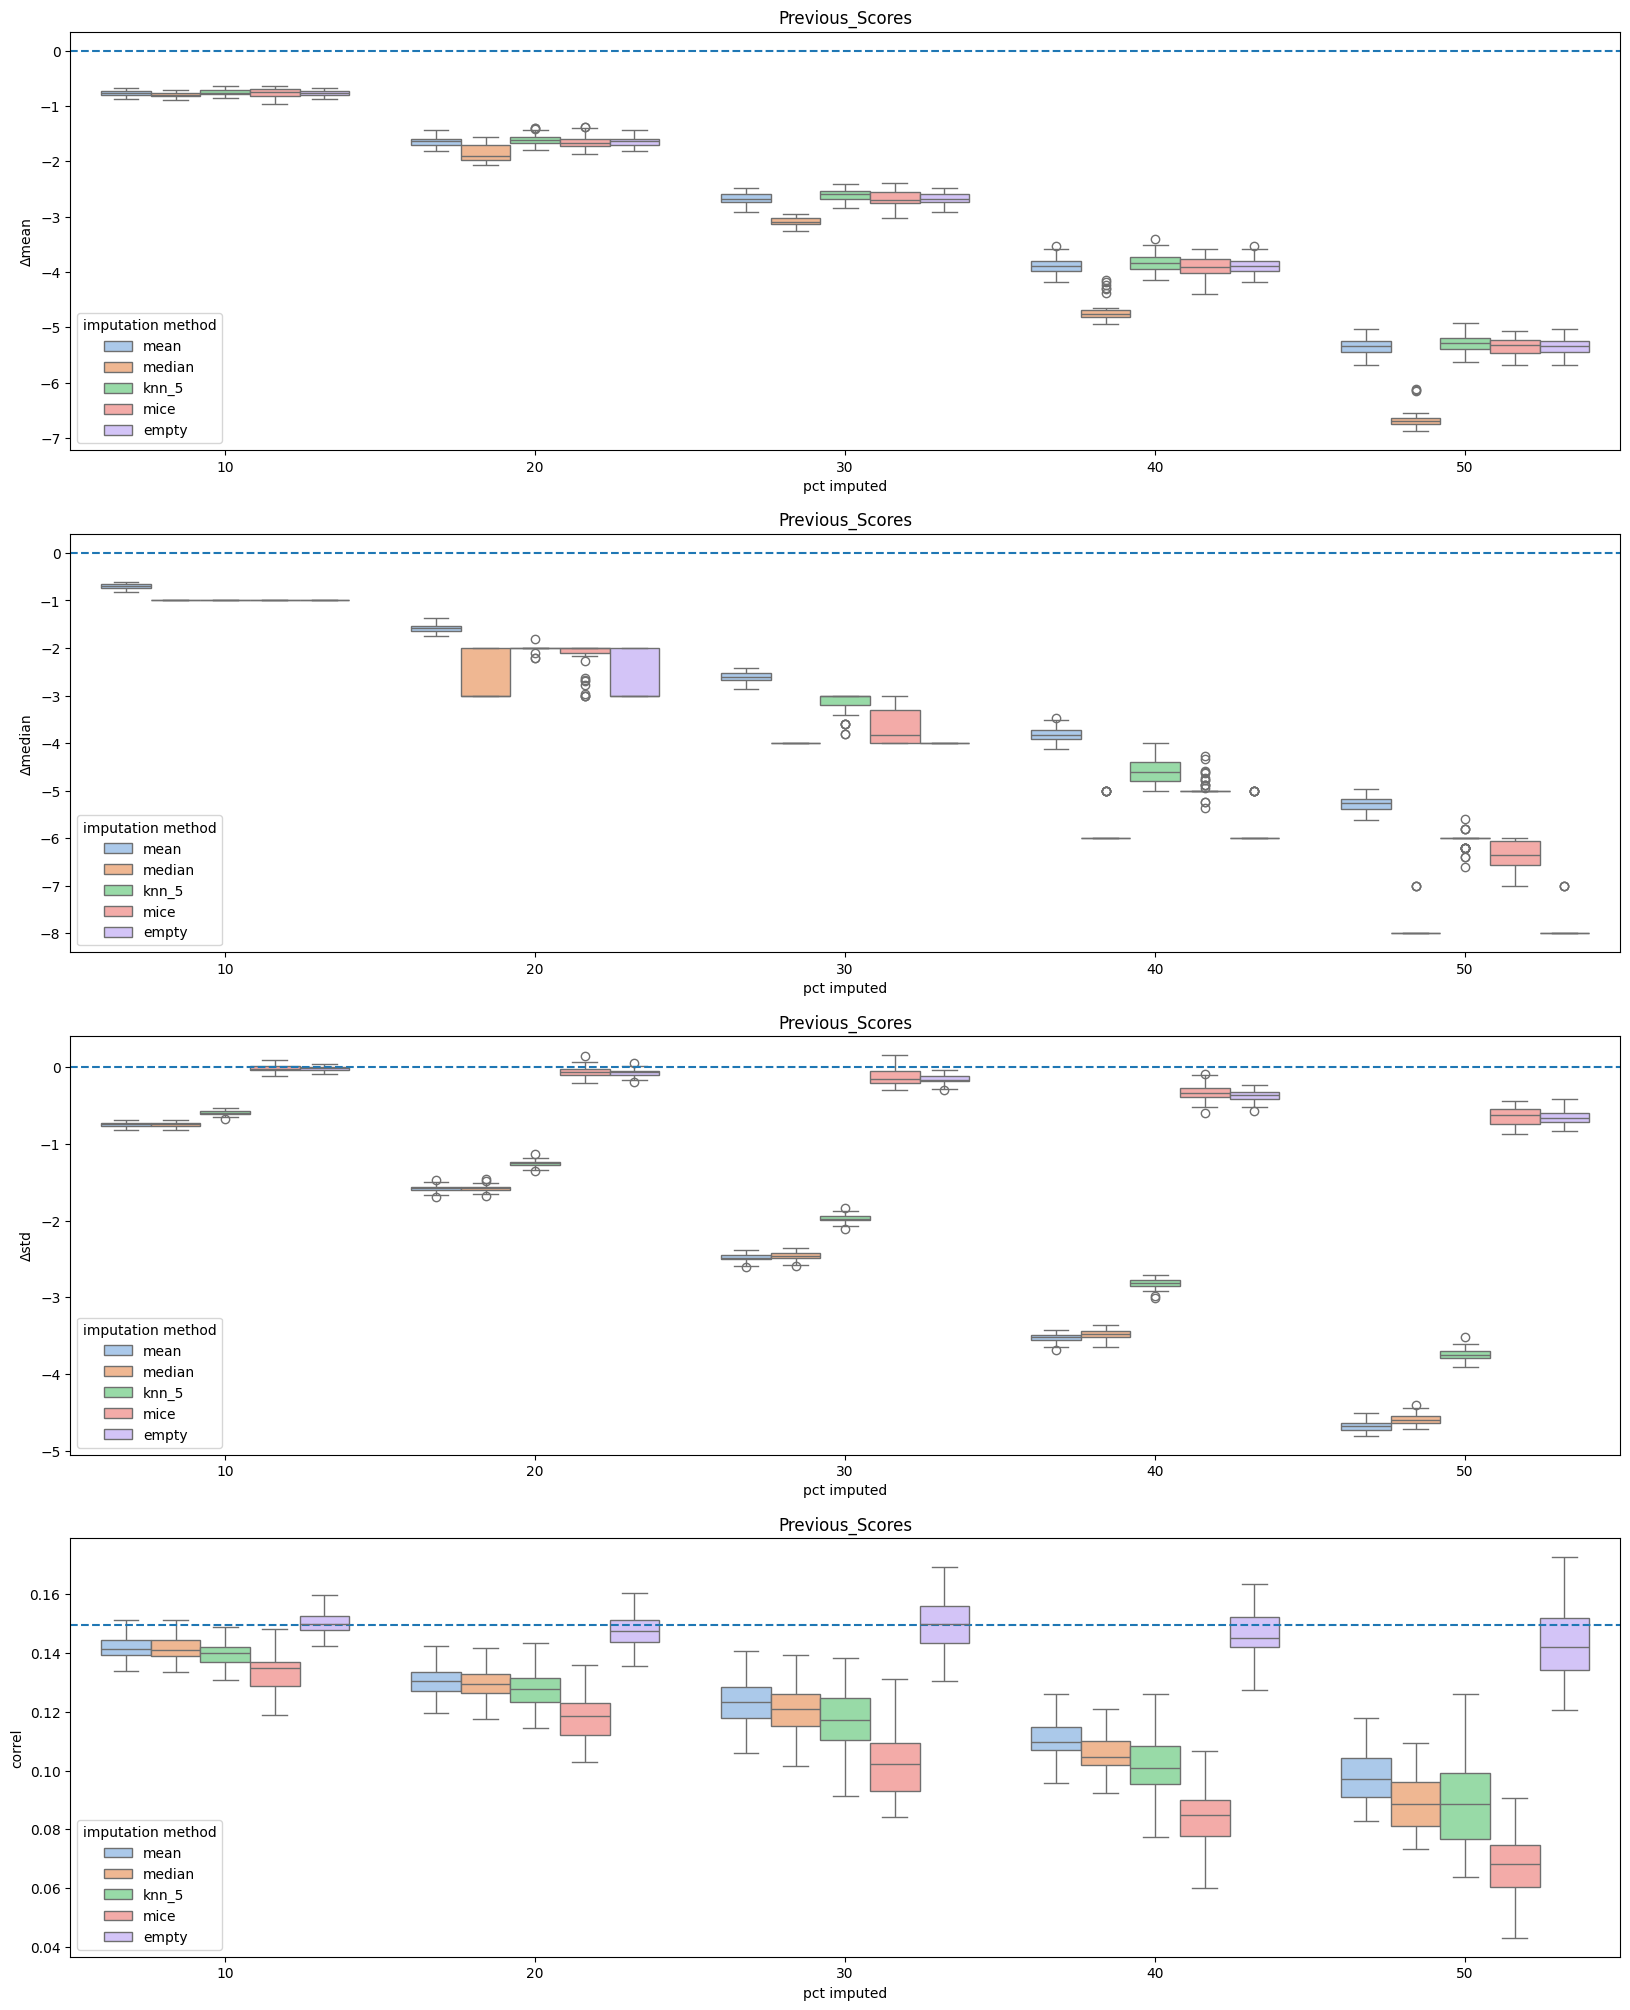

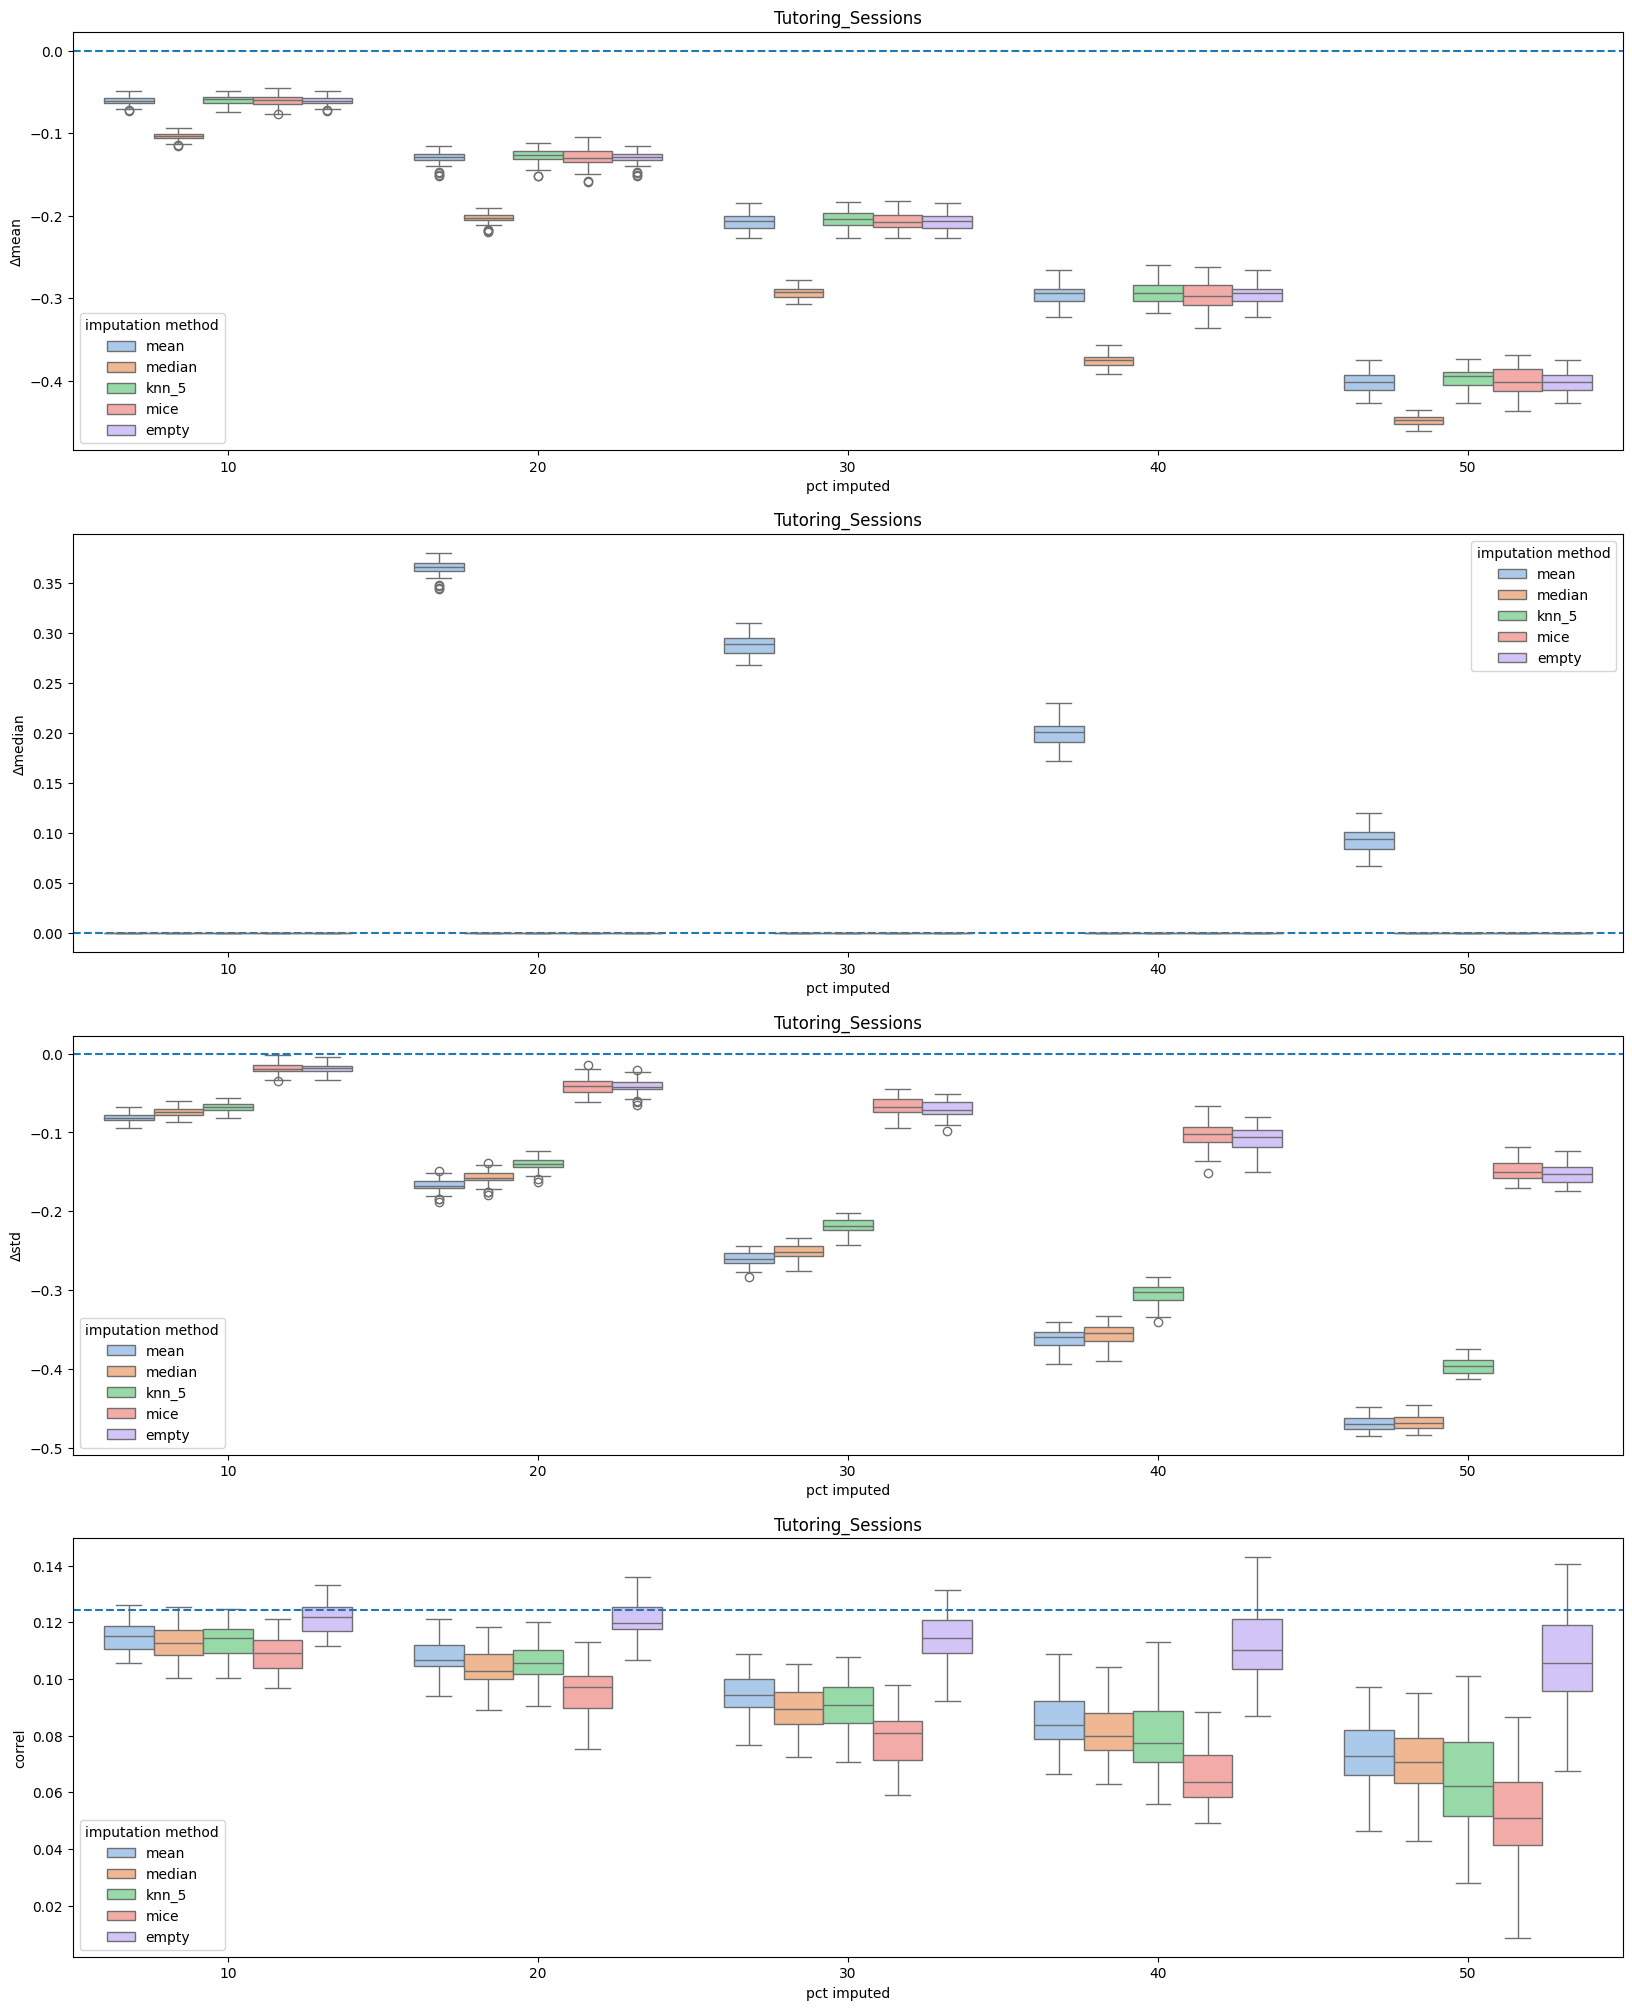

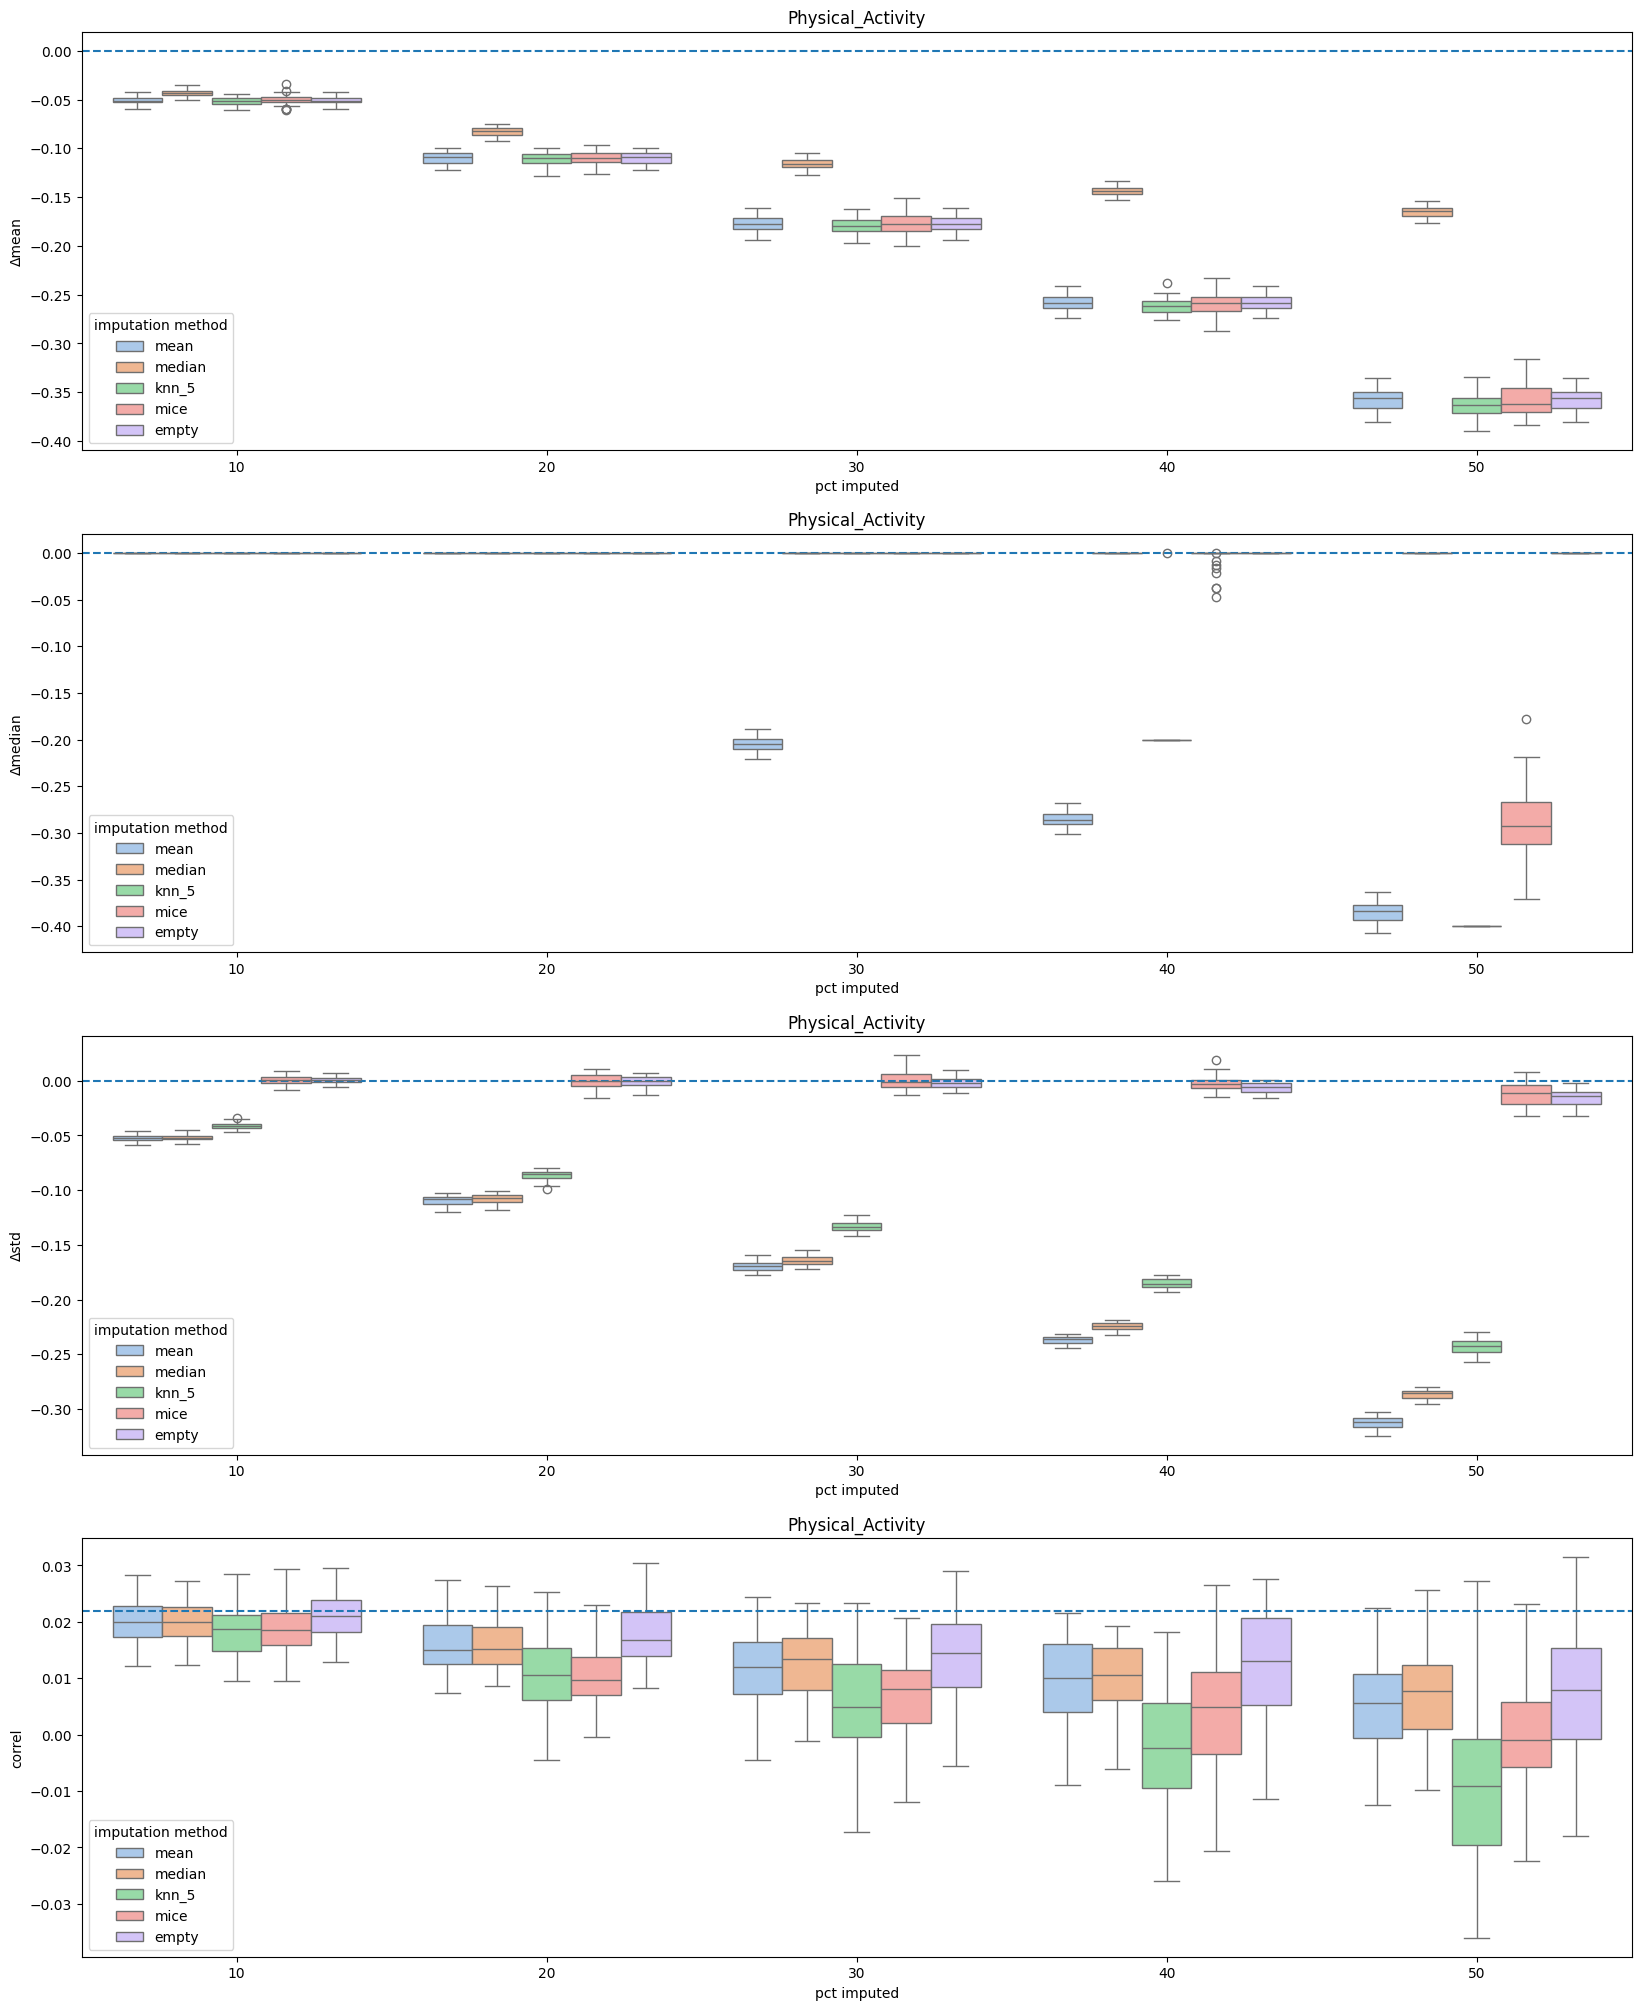

In [91]:
X = df[quantitativos].copy()
y = df[class_col].astype(int).copy()  # 0/1

# MNAR
df_vis1 = generate_results(X, y, 'mean', missing_mech='MNAR')
df_vis2 = generate_results(X, y, 'median', missing_mech='MNAR')
df_vis3 = generate_results(X, y, 'knn_5', missing_mech='MNAR')
# df_vis4 = generate_results(X, y, 'missforest', missing_mech='MNAR')
df_vis5 = generate_results(X, y, 'mice', missing_mech='MNAR')
df_vis6 = generate_results(X, y, 'empty', missing_mech='MNAR')

df_vis = pd.concat([df_vis1, df_vis2, df_vis3, df_vis5, df_vis6])

for col in df_quant:
    if col == max_col:
        value = max_value
    elif col == min_col:
        value = min_value
    elif col == az_col:
        value = almost_zero
    else:
        value = correlations[col]
    generate_vis(df_vis, col, value)

### MCAR

Processing Hours_Studied with mean
Processing Attendance with mean
Processing Sleep_Hours with mean
Processing Previous_Scores with mean
Processing Tutoring_Sessions with mean
Processing Physical_Activity with mean
Processing Hours_Studied with median
Processing Attendance with median
Processing Sleep_Hours with median
Processing Previous_Scores with median
Processing Tutoring_Sessions with median
Processing Physical_Activity with median
Processing Hours_Studied with knn_5
Processing Attendance with knn_5
Processing Sleep_Hours with knn_5
Processing Previous_Scores with knn_5
Processing Tutoring_Sessions with knn_5
Processing Physical_Activity with knn_5
Processing Hours_Studied with mice
Processing Attendance with mice
Processing Sleep_Hours with mice
Processing Previous_Scores with mice
Processing Tutoring_Sessions with mice
Processing Physical_Activity with mice
Processing Hours_Studied with empty
Processing Attendance with empty
Processing Sleep_Hours with empty
Processing Previous

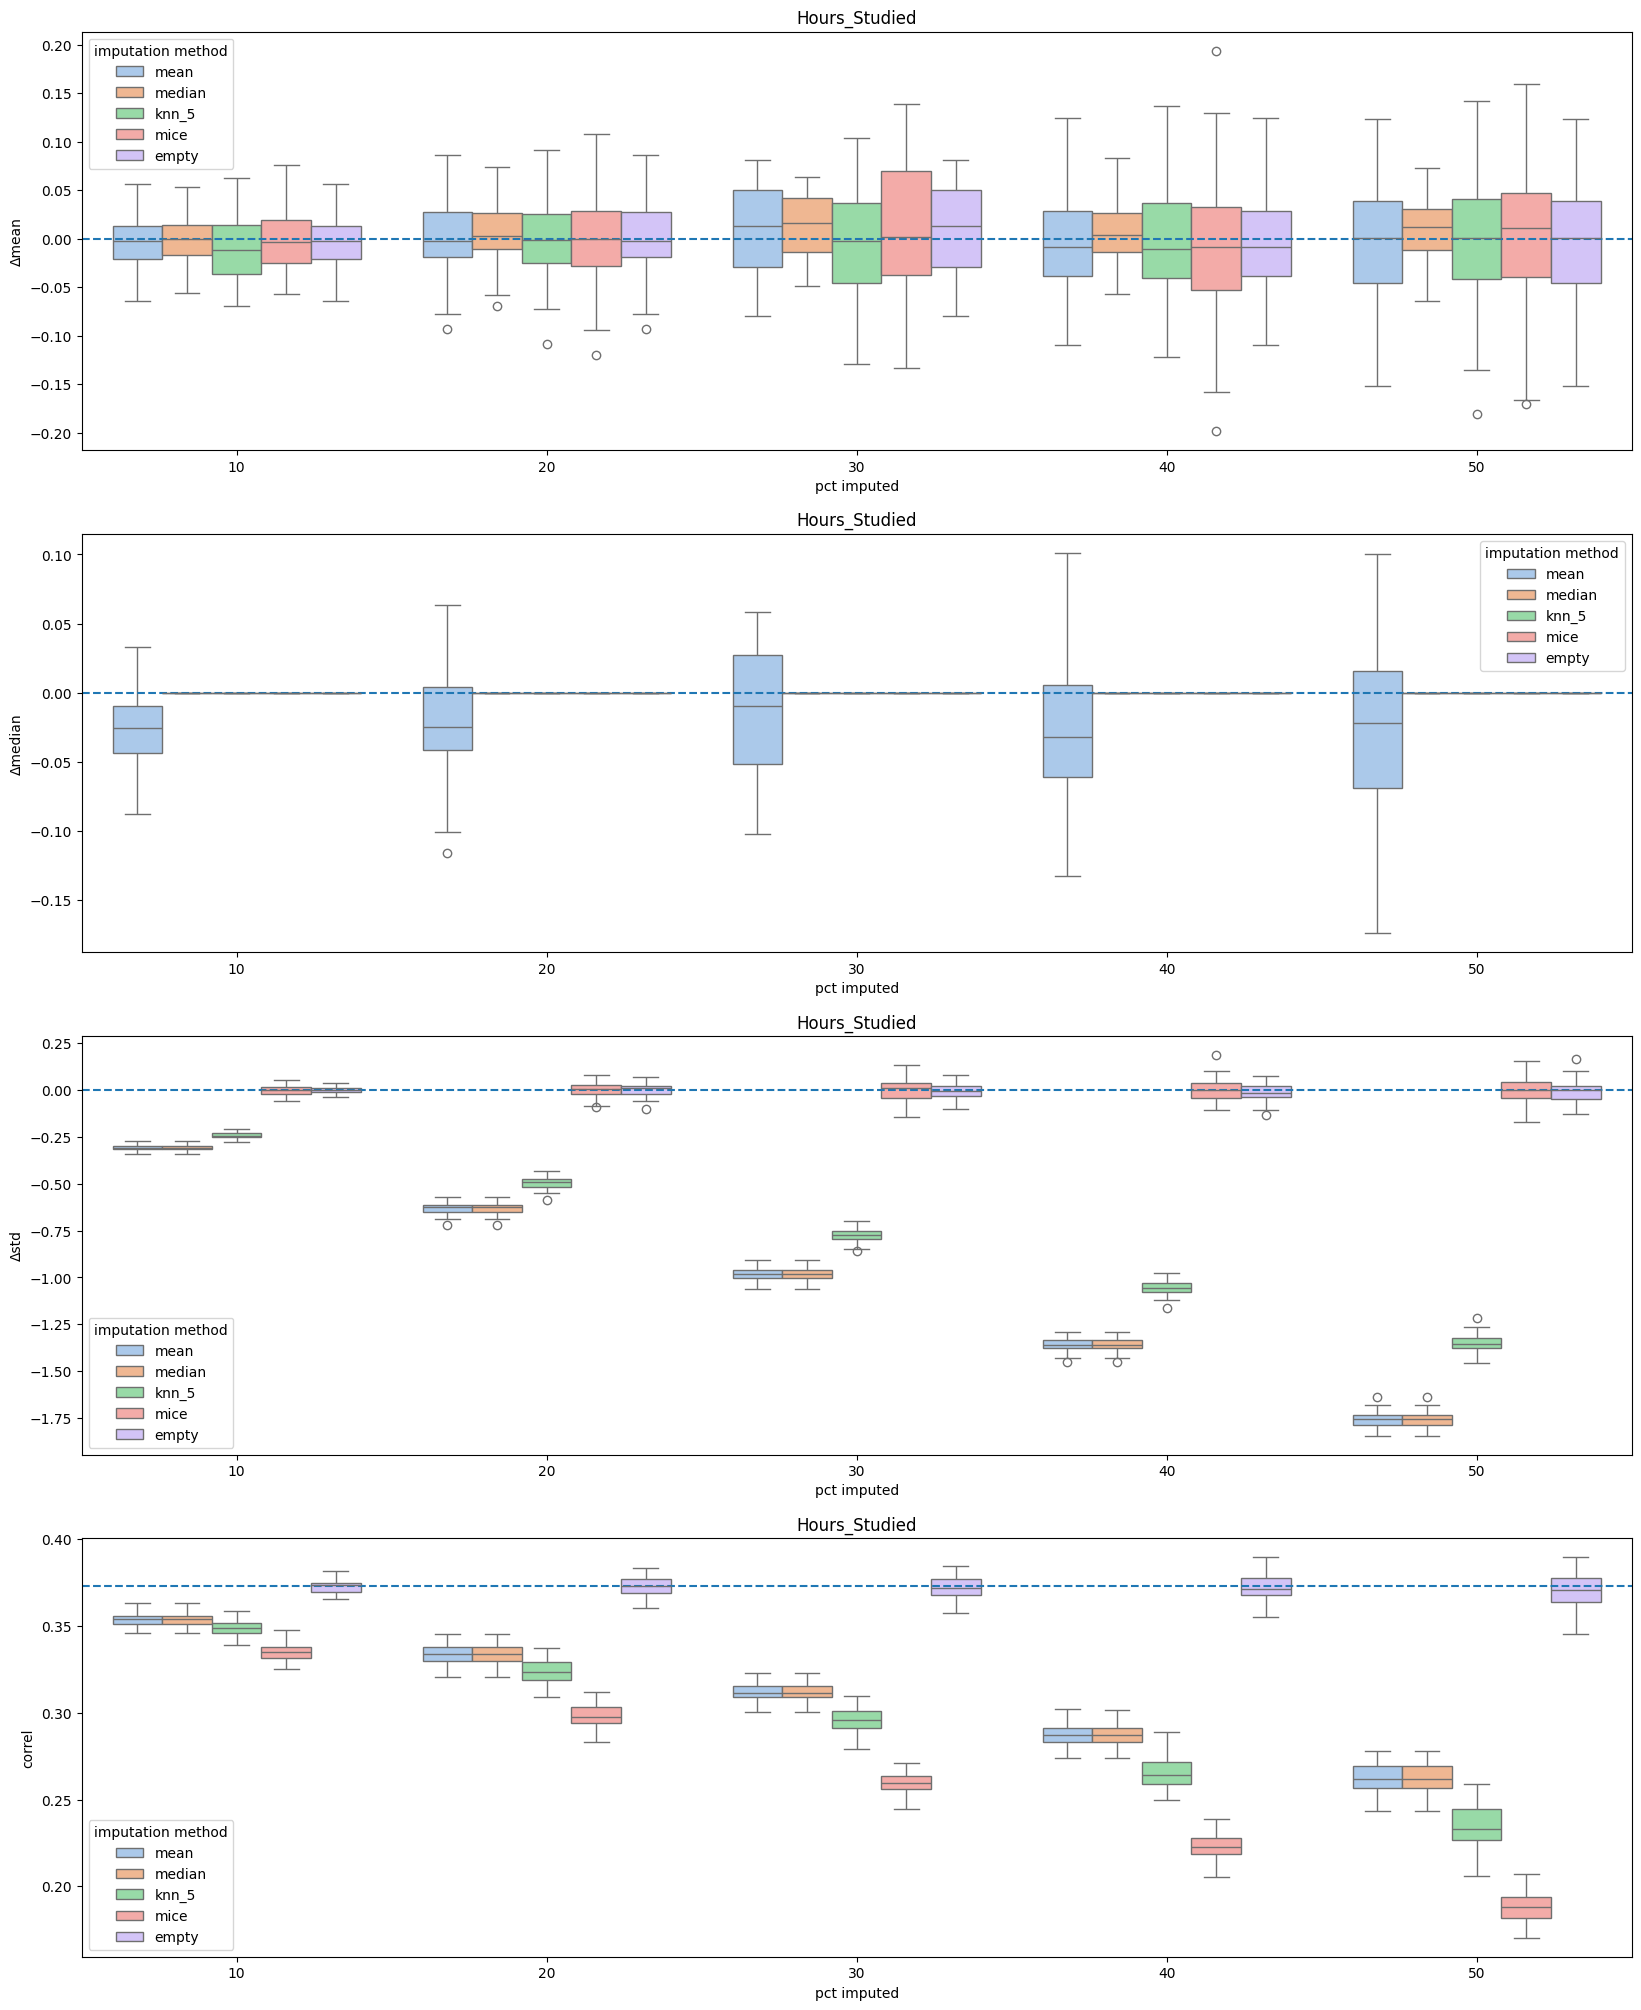

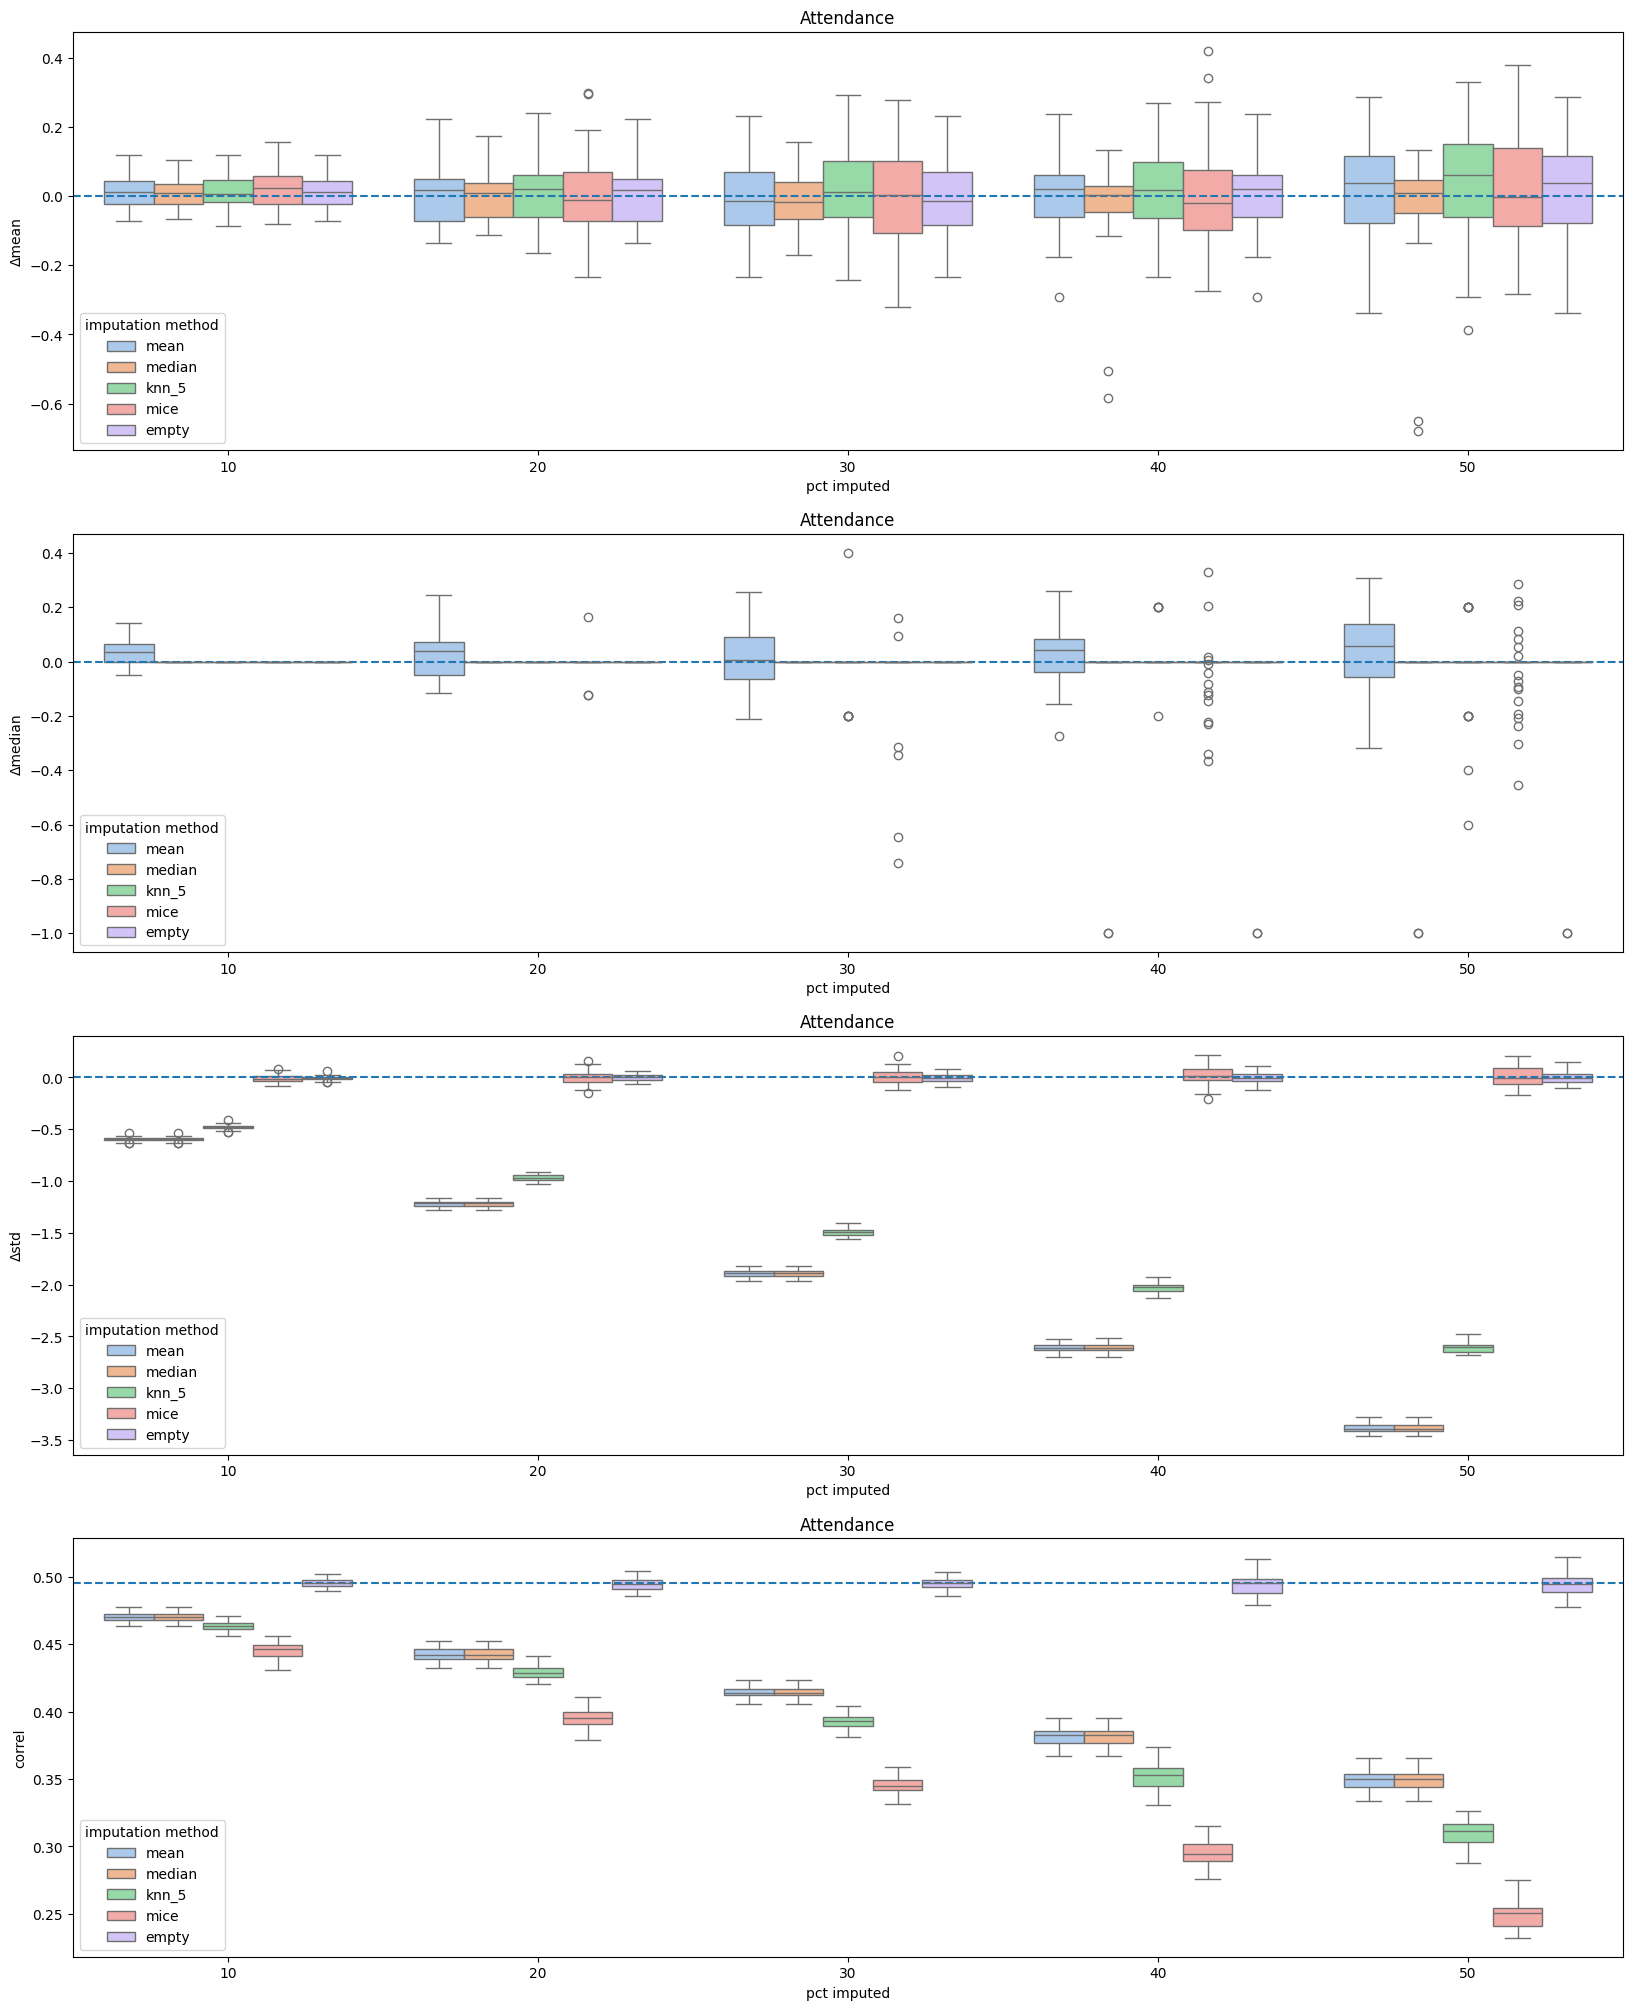

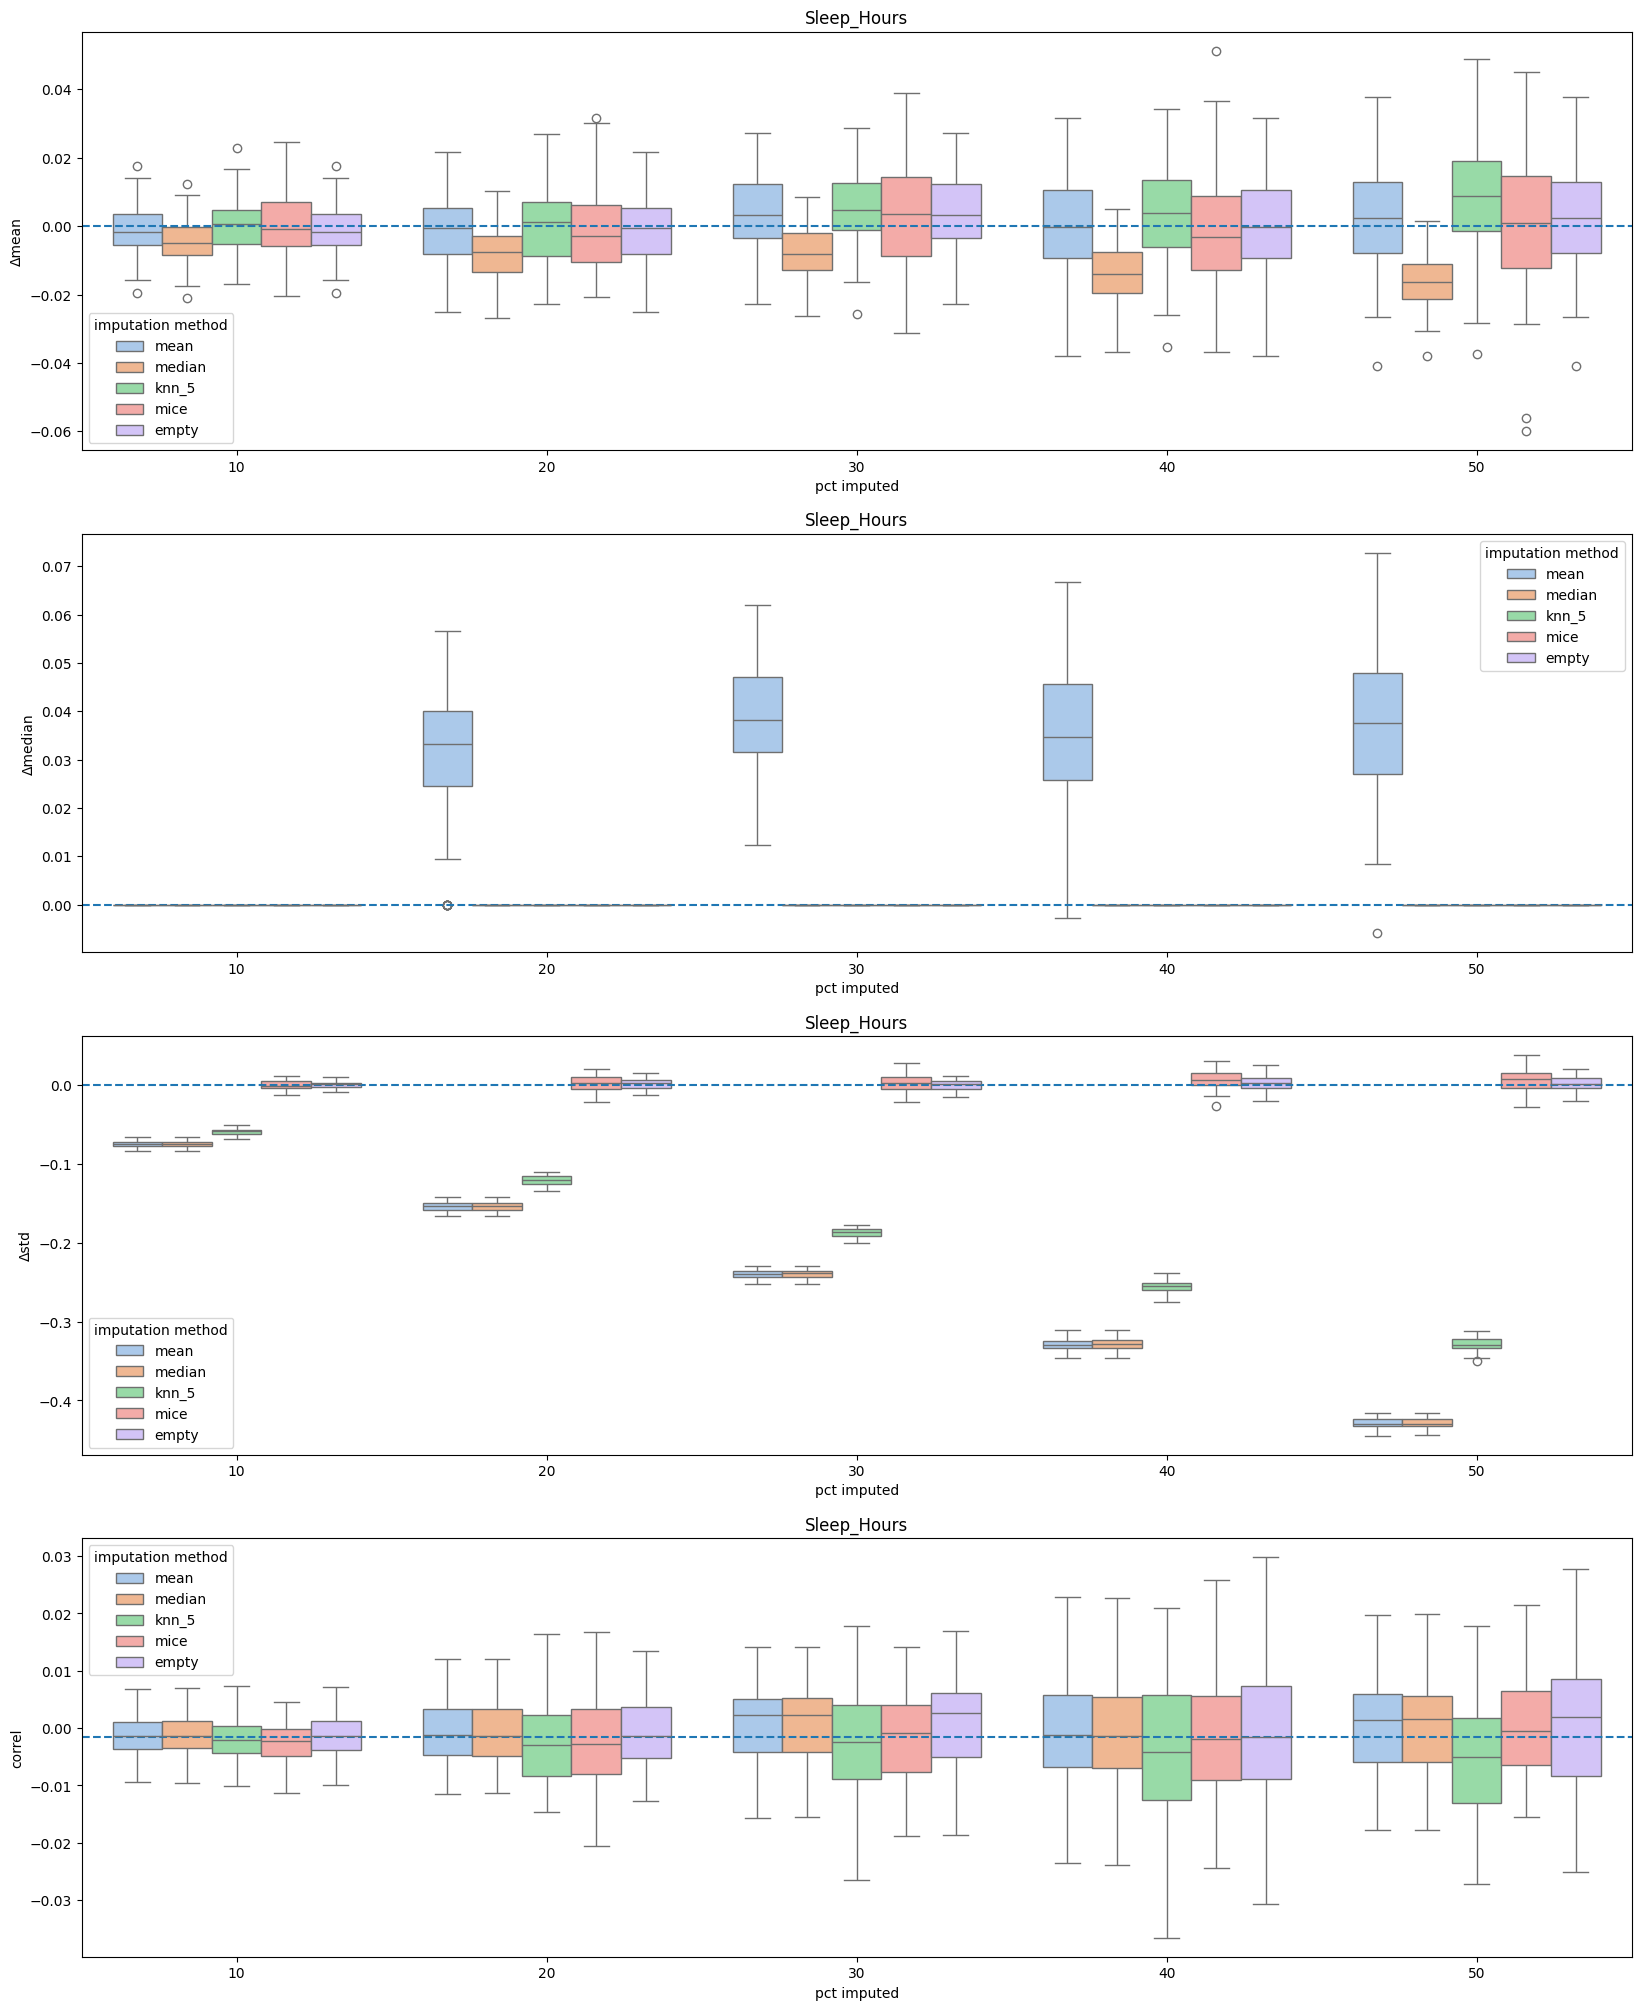

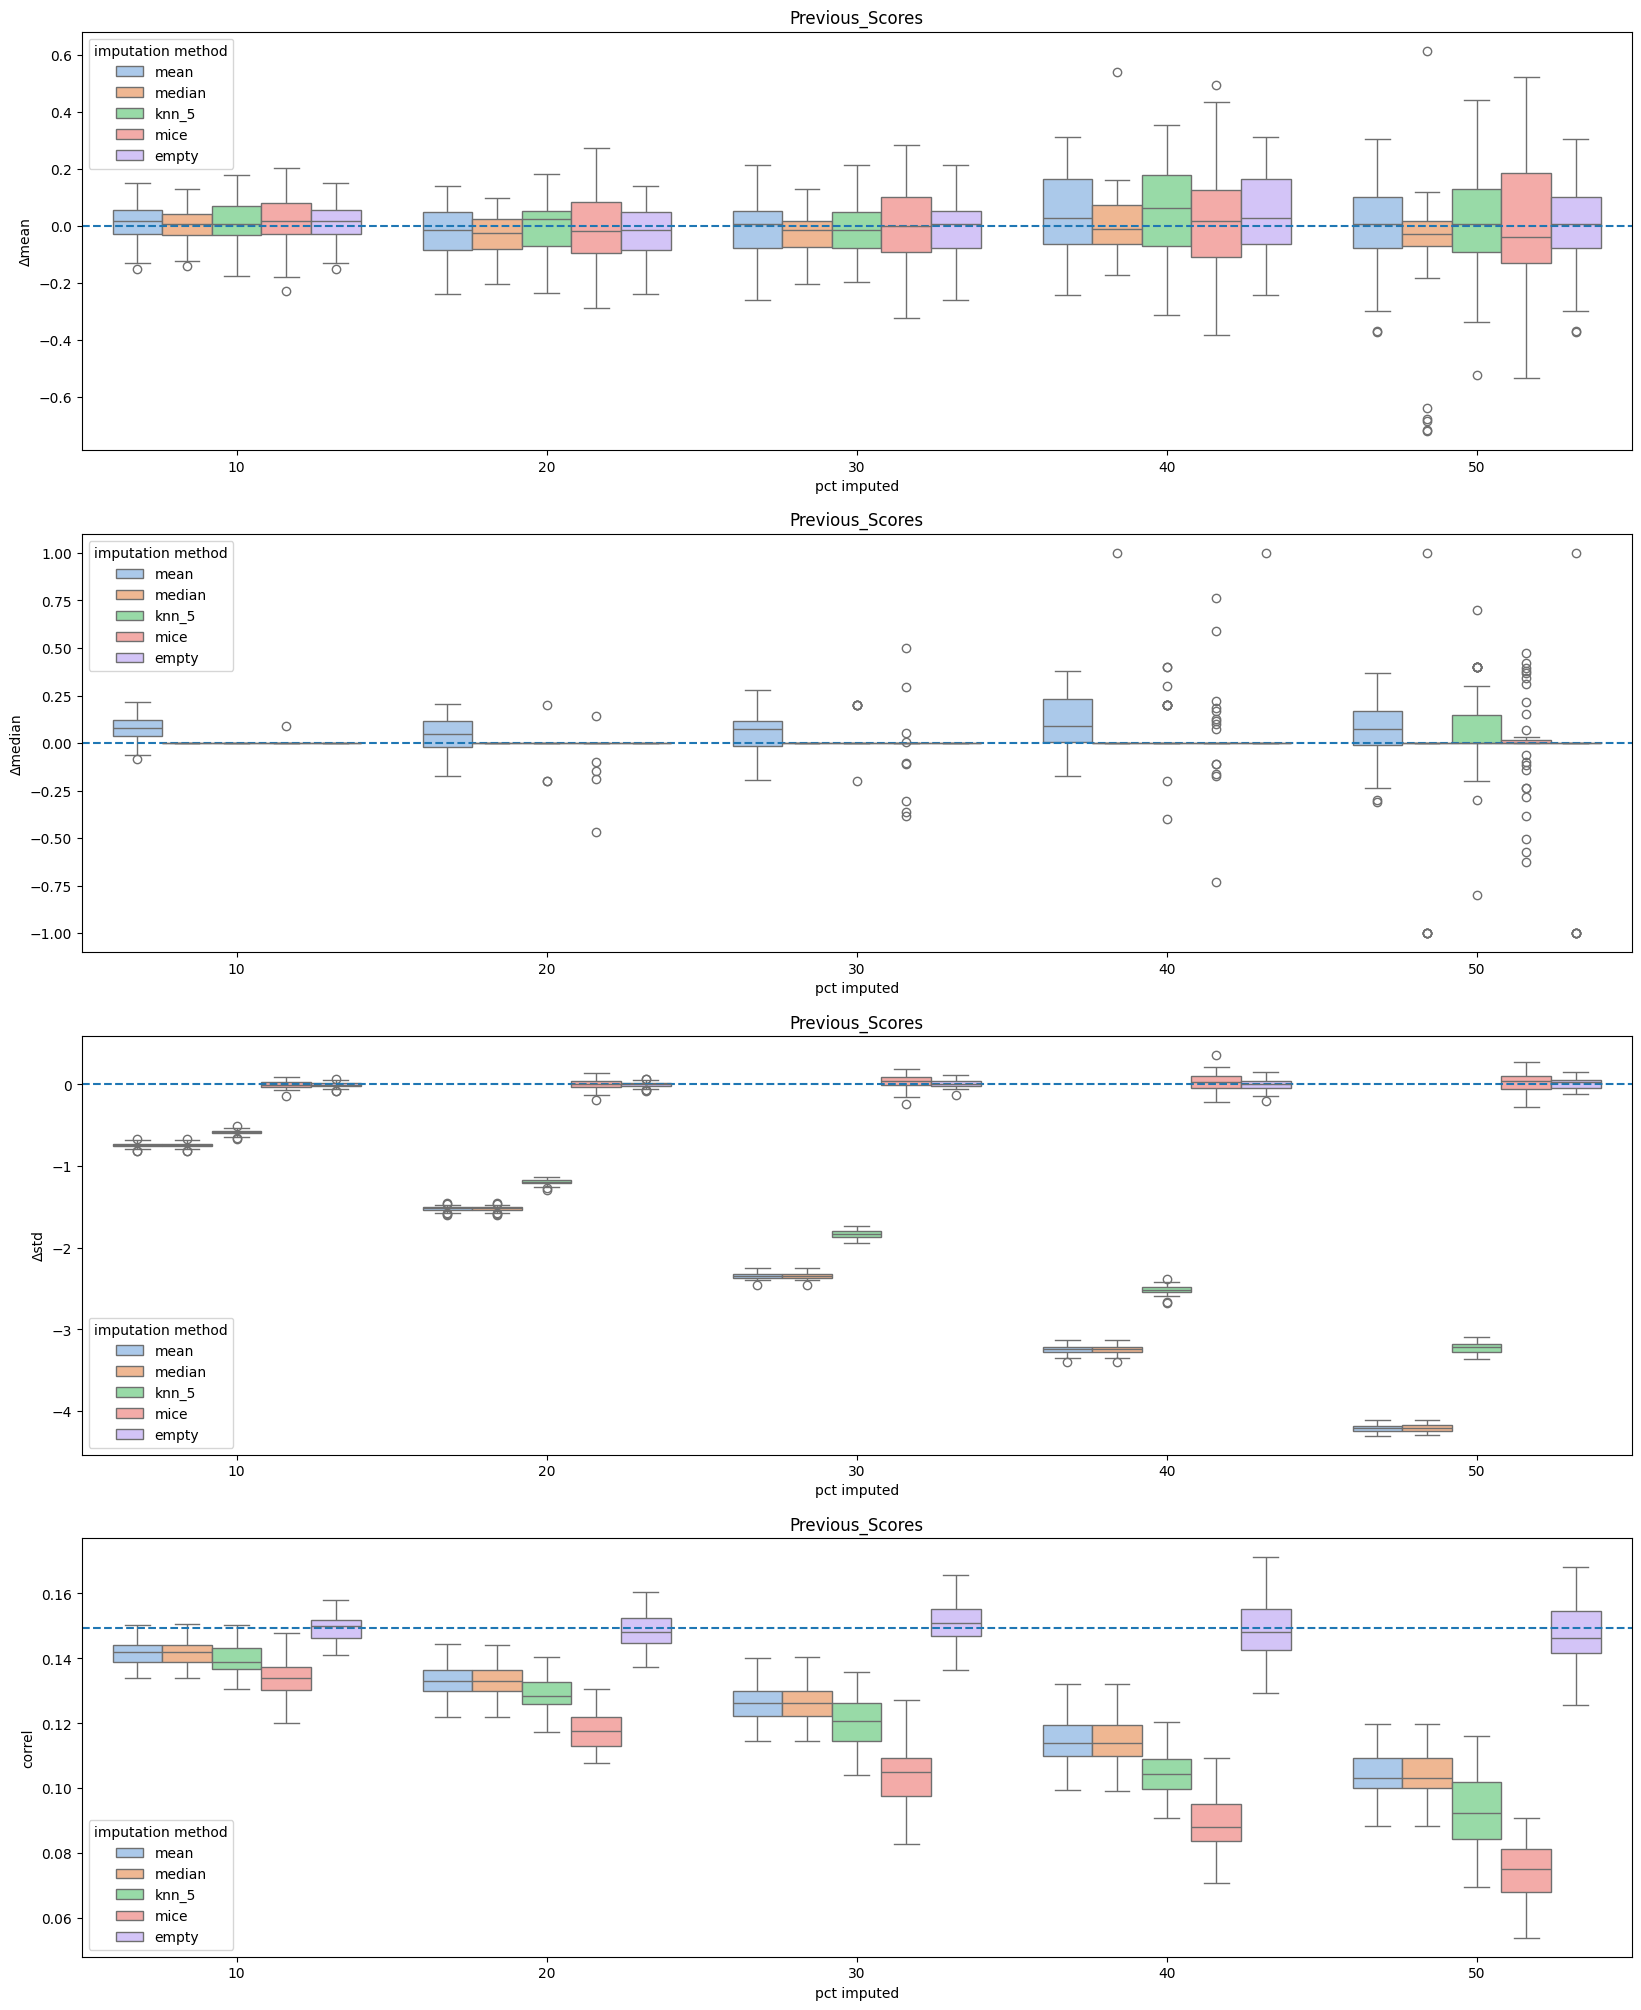

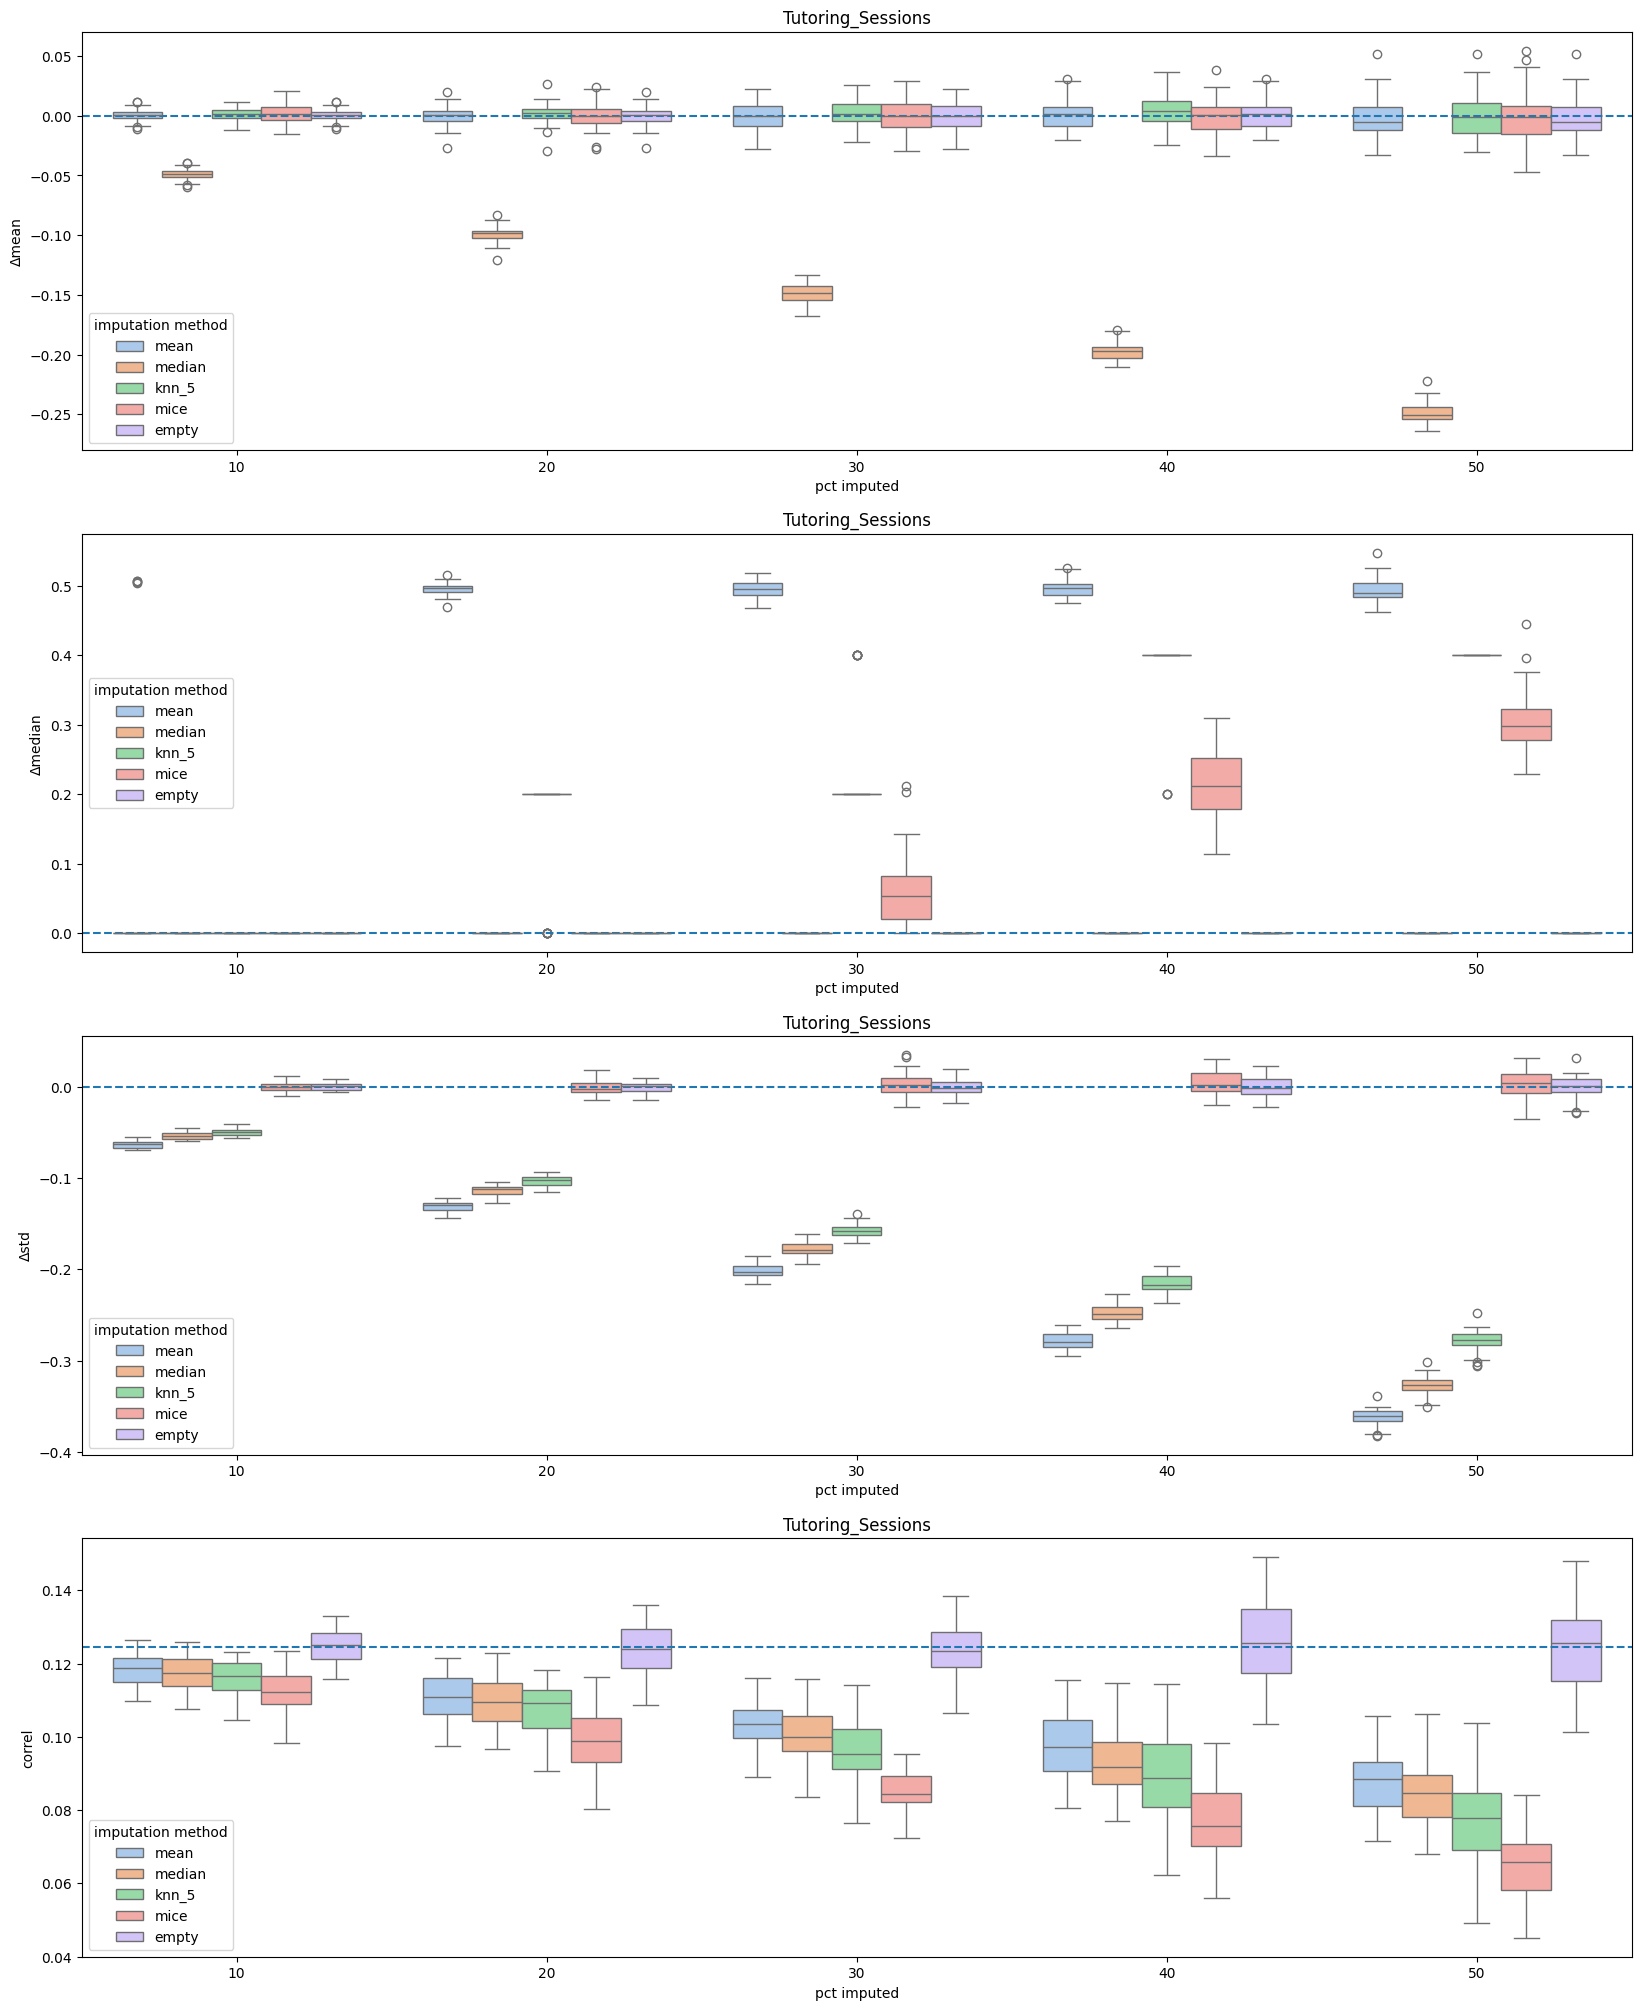

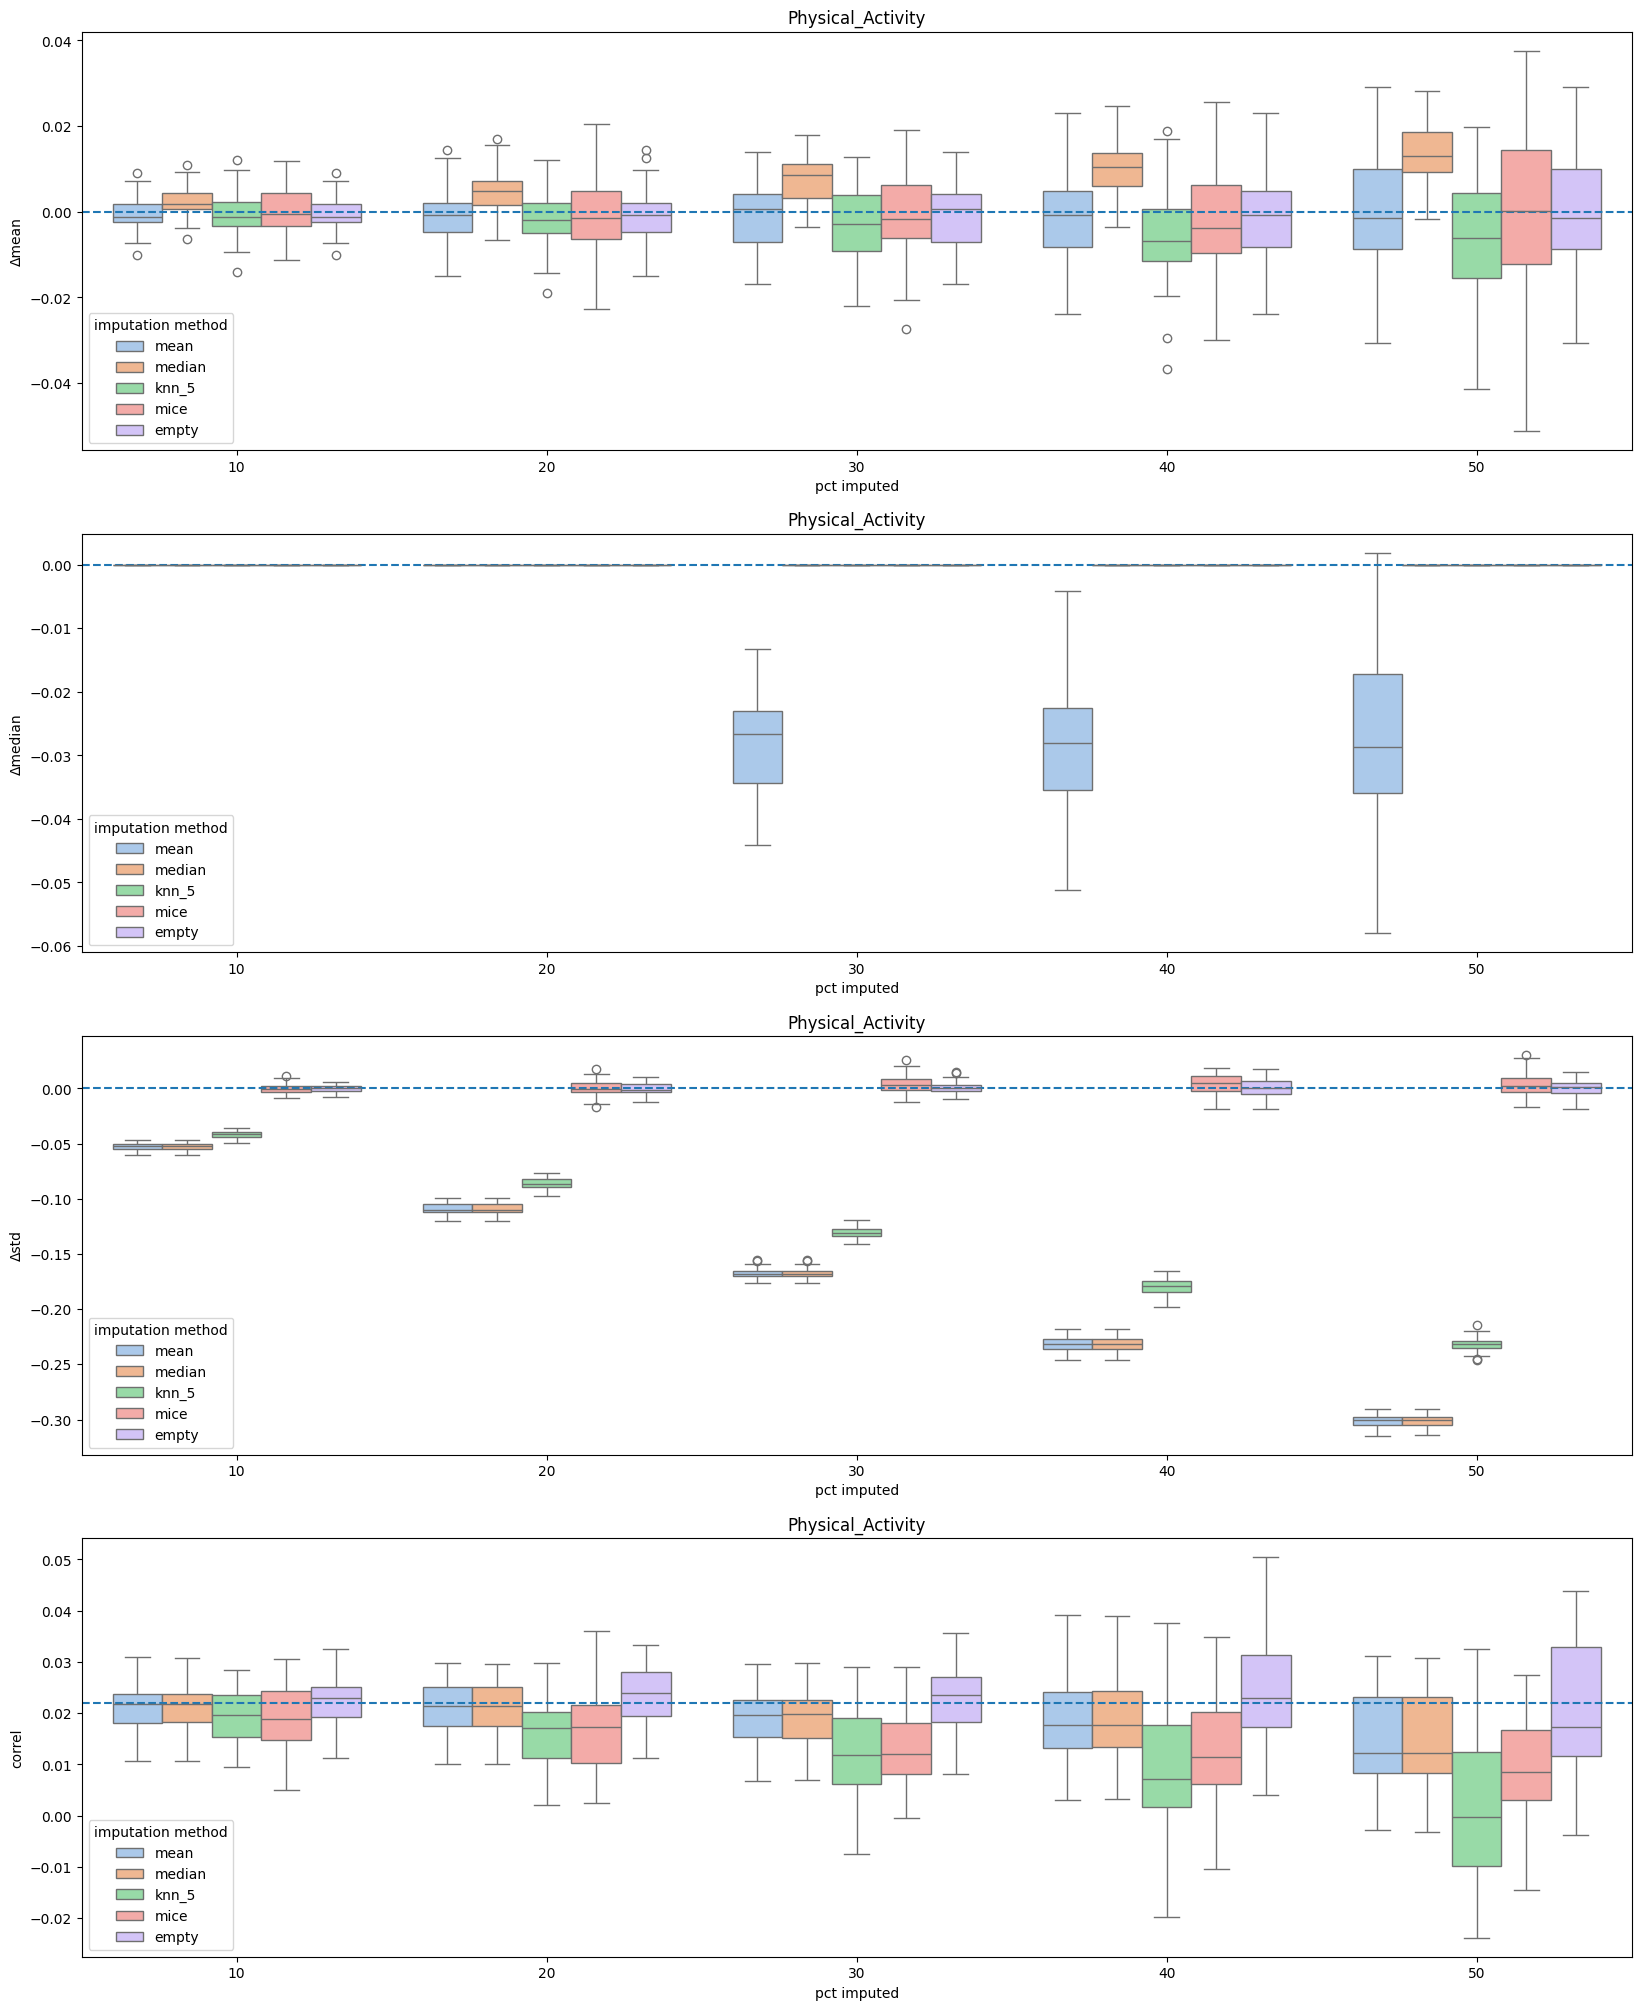

In [113]:
## retirar de df[quantitativos] a coluna age
quantitativos = [col for col in quantitativos if col != 'age']

X = df[quantitativos].copy()
y = df[class_col].astype(int).copy()  # 0/1

# MNAR
df_vis1 = generate_results(X, y, 'mean', missing_mech='MCAR')
df_vis2 = generate_results(X, y, 'median', missing_mech='MCAR')
df_vis3 = generate_results(X, y, 'knn_5', missing_mech='MCAR')
# df_vis4 = generate_results(X, y, 'missforest', missing_mech='MCAR')
df_vis5 = generate_results(X, y, 'mice', missing_mech='MCAR')
df_vis6 = generate_results(X, y, 'empty', missing_mech='MCAR')

df_vis = pd.concat([df_vis1, df_vis2, df_vis3, df_vis5, df_vis6])

for col in df_quant:
    if col == max_col:
        value = max_value
    elif col == min_col:
        value = min_value
    elif col == az_col:
        value = almost_zero
    else:
        value = correlations[col]
    generate_vis(df_vis, col, value)